In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import ast
import glob
import scipy.stats as stats
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.multicomp import pairwise_tukeyhsd

from sklearn.metrics import mean_squared_error, r2_score
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input, LSTM, Dense, Flatten, Reshape, RepeatVector, TimeDistributed
from tensorflow.keras.optimizers import Adam

from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, f1_score

import joblib

from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import MinMaxScaler

In [2]:
not_non_features = [
       'LOAD|1', 'LOAD|2', 'LOAD|3', 'LOAD|6',
       'ENC_POS|1', 'ENC_POS|2', 'ENC_POS|3','ENC_POS|6',
       'CTRL_DIFF2|1', 'CTRL_DIFF2|2', 'CTRL_DIFF2|3', 'CTRL_DIFF2|6',
       'TORQUE|1', 'TORQUE|2', 'TORQUE|3', 'TORQUE|6',
       'DES_POS|1', 'DES_POS|2', 'DES_POS|3', 'DES_POS|6',

       #'CURRENT|1', 'CURRENT|2', 'CURRENT|3',
        

       'CTRL_DIFF|1', 'CTRL_DIFF|2', 'CTRL_DIFF|3' ,'CTRL_DIFF|6',
       'CTRL_POS|1', 'CTRL_POS|2', 'CTRL_POS|3', 'CTRL_POS|6',
       'VEL_FFW|1', 'VEL_FFW|2','VEL_FFW|3', 'VEL_FFW|6',
       #'POWER|1','POWER|2', 'POWER|3', 'POWER|6',
       'CONT_DEV|1','CONT_DEV|2', 'CONT_DEV|3', 'CONT_DEV|6',
       #'A_DBD|0',
       'CMD_SPEED|1', 'CMD_SPEED|2', 'CMD_SPEED|3', 'CMD_SPEED|6',
       'TORQUE_FFW|1', 'TORQUE_FFW|2', 'TORQUE_FFW|3', 'TORQUE_FFW|6',
       'ENC1_POS|1', 'ENC1_POS|2', 'ENC1_POS|3','ENC1_POS|6',
       'ENC2_POS|1', 'ENC2_POS|2', 'ENC2_POS|3', 'ENC2_POS|6']
target = 'CURRENT|6'

In [49]:
file_path = ['C:/Users/genty/Hiwi-TimeSeries/dataset/DatAmount_dataset_new/1_CMX/CMX1_AL_CP1.csv',
             'C:/Users/genty/Hiwi-TimeSeries/dataset/DatAmount_dataset_new/1_CMX/CMX1_AL_CP2.csv',
             'C:/Users/genty/Hiwi-TimeSeries/dataset/DatAmount_dataset_new/1_CMX/CMX1_S_CP1.csv',
             'C:/Users/genty/Hiwi-TimeSeries/dataset/DatAmount_dataset_new/1_CMX/CMX1_S_CP2.csv',
             'C:/Users/genty/Hiwi-TimeSeries/dataset/DatAmount_dataset_new/2_DMC/DMC2_AL_CP1.csv',
             'C:/Users/genty/Hiwi-TimeSeries/dataset/DatAmount_dataset_new/2_DMC/DMC2_AL_CP2.csv',
             'C:/Users/genty/Hiwi-TimeSeries/dataset/DatAmount_dataset_new/2_DMC/DMC2_S_CP1.csv',
             'C:/Users/genty/Hiwi-TimeSeries/dataset/DatAmount_dataset_new/2_DMC/DMC2_S_CP2.csv']

In [4]:
output_folder = "C:/Users/genty/Hiwi-TimeSeries/output/Autoencoder/"

# Global Model

In [5]:
result_summary = pd.read_csv("C:/Users/genty/Hiwi-TimeSeries/output/8dataset/result_summary_lstm_new.csv")
filtered_summary = result_summary[(result_summary["Data_Split"] == 0.2) & (result_summary["Features"] == "all")]
filtered_summary = filtered_summary.drop(columns=["Data_Split","Features","RunTime"])
filtered_summary = filtered_summary.reset_index(drop=True)
filtered_summary = filtered_summary[["Dataset","Train_R2","Test_R2","Train_RMSE","Test_RMSE"]]
filtered_summary.to_csv(os.path.join(output_folder, f"Global_LSTM_Summmary_2080.csv"), index=False)
print(filtered_summary)

           Dataset  Train_R2  Test_R2  Train_RMSE  Test_RMSE
0  CMX1_AL_CP1.csv    0.9996   0.8577      0.0172     0.3800
1  CMX1_AL_CP2.csv    0.9988  -1.0846      0.0300     1.1650
2   CMX1_S_CP1.csv    1.0000   0.8420      0.0119     1.0510
3   CMX1_S_CP2.csv    0.9999  -0.3814      0.0142     1.5052
4  DMC2_AL_CP1.csv    0.9990  -4.4139      0.0344     4.1321
5  DMC2_AL_CP2.csv    0.9955  -1.2232      0.1405     4.5284
6   DMC2_S_CP1.csv    0.9997   0.1944      0.0590     2.8296
7   DMC2_S_CP2.csv    0.9901  -0.1073      0.2122     3.0129


In [40]:
for file in file_path:
    df = pd.read_csv(file)
    print(len(df))

433666
74822
244772
45468
510050
64337
263913
42016


# AE

This is a simple overcomplete auto encoder.

In [28]:
def autoencodermodel(input_dim, dim):
        input_layer = Input(shape=(input_dim,))
        encoded = Dense(dim, activation='relu')(input_layer)
        decoded = Dense(input_dim, activation='linear')(encoded)
        autoencoder = Model(inputs=input_layer, outputs=decoded)
        autoencoder.compile(optimizer='adam', loss='mse')
        return autoencoder

13553/13553 ━━━━━━━━━━━━━━━━━━━━ 15s 1ms/step


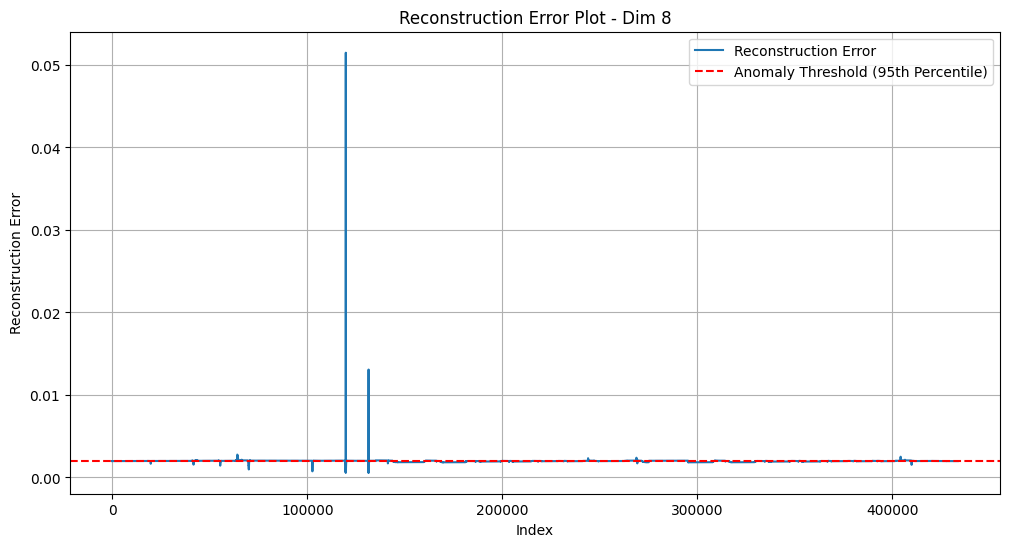

13553/13553 ━━━━━━━━━━━━━━━━━━━━ 15s 1ms/step


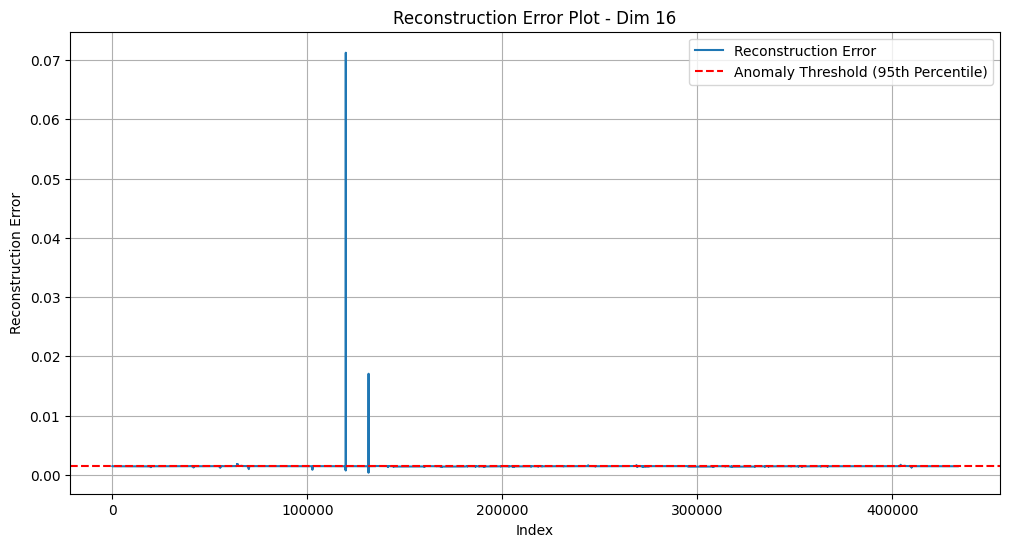

13553/13553 ━━━━━━━━━━━━━━━━━━━━ 15s 1ms/step


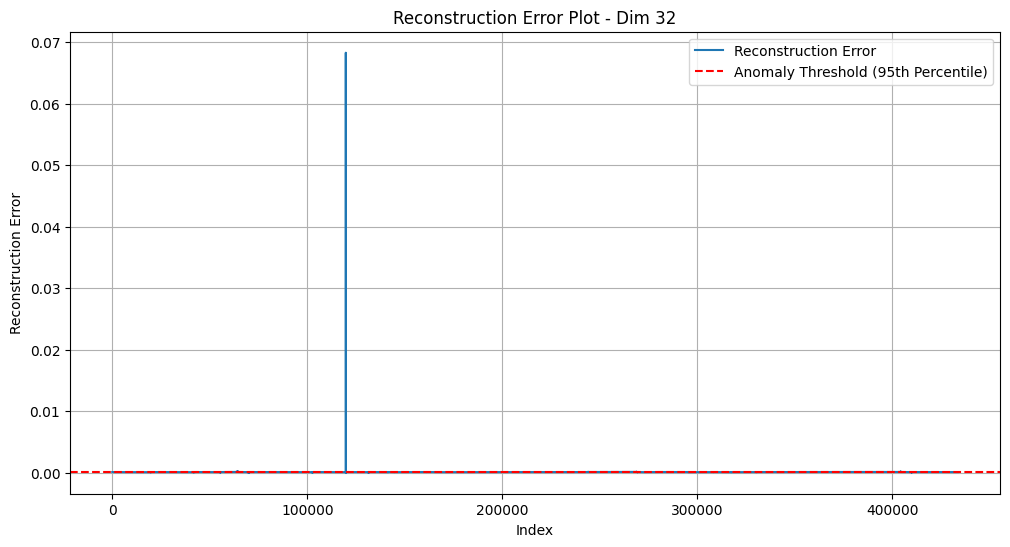

13553/13553 ━━━━━━━━━━━━━━━━━━━━ 15s 1ms/step


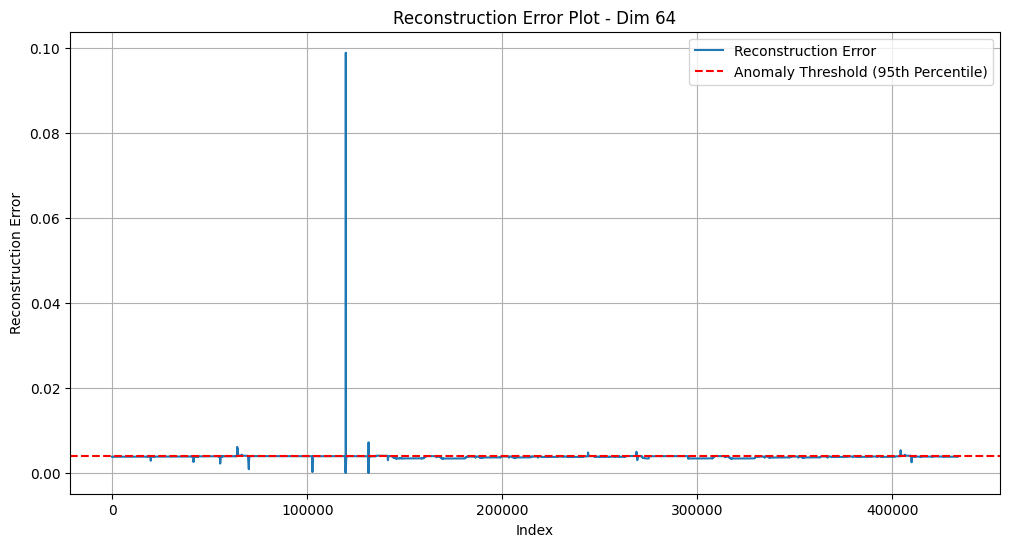

13553/13553 ━━━━━━━━━━━━━━━━━━━━ 14s 1ms/step


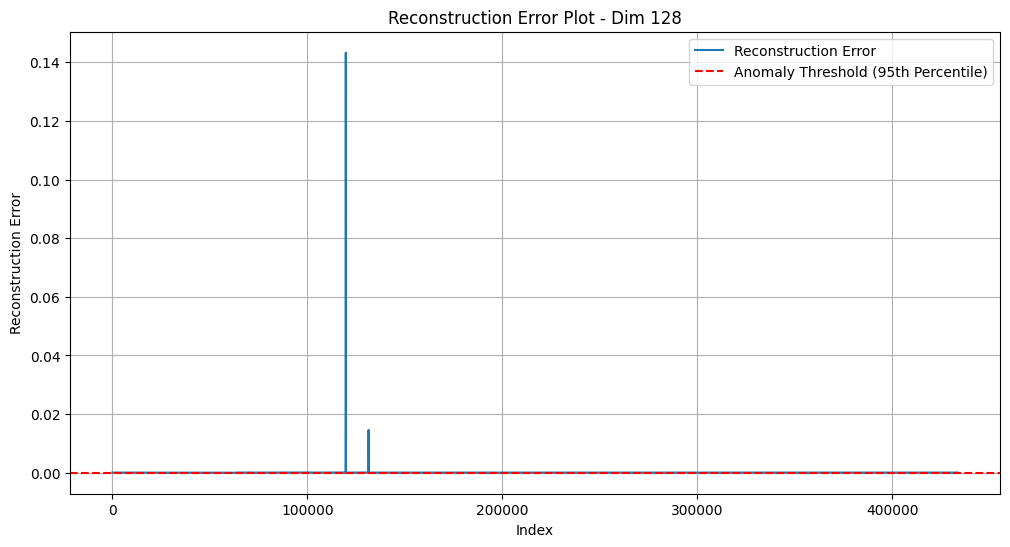

{'Dataset': 'CMX1_AL_CP1.csv', 'Latent_Space': 128, 'Num_Peaks': 21299, 'Peak_Indices': [19674, 19675, 19678, 19680, 19683, 19684, 19685, 19686, 19687, 19688, 19689, 19690, 19691, 19692, 19693, 19694, 19695, 19696, 19697, 19698, 19699, 19700, 19701, 19702, 19703, 19704, 19705, 19706, 19707, 19708, 19709, 19710, 19711, 19712, 19713, 19714, 19715, 19716, 19717, 19718, 19719, 19720, 19721, 19722, 19723, 19724, 19725, 19726, 19727, 19728, 19729, 19730, 19731, 19732, 19733, 19734, 19735, 19736, 19737, 19738, 19739, 19740, 19741, 19742, 19743, 19744, 19745, 19746, 19747, 19748, 19749, 19750, 19751, 19752, 19753, 19754, 19755, 19756, 19757, 19758, 19759, 19760, 19761, 19762, 19763, 19764, 19765, 19766, 19767, 19768, 19769, 19770, 19771, 19773, 19774, 19775, 19776, 19778, 19779, 19782, 19783, 19784, 19785, 19787, 19788, 19791, 19792, 19795, 41618, 41624, 41625, 41626, 41627, 41628, 41629, 41630, 41631, 41632, 41633, 41634, 41635, 41636, 41637, 41638, 41639, 41640, 41641, 41642, 41643, 41644, 4

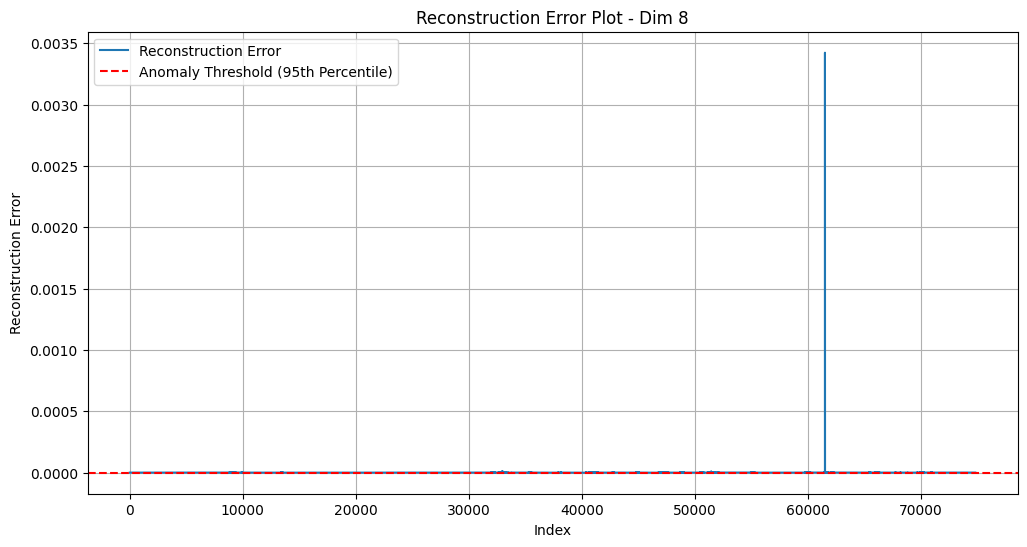

2339/2339 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step


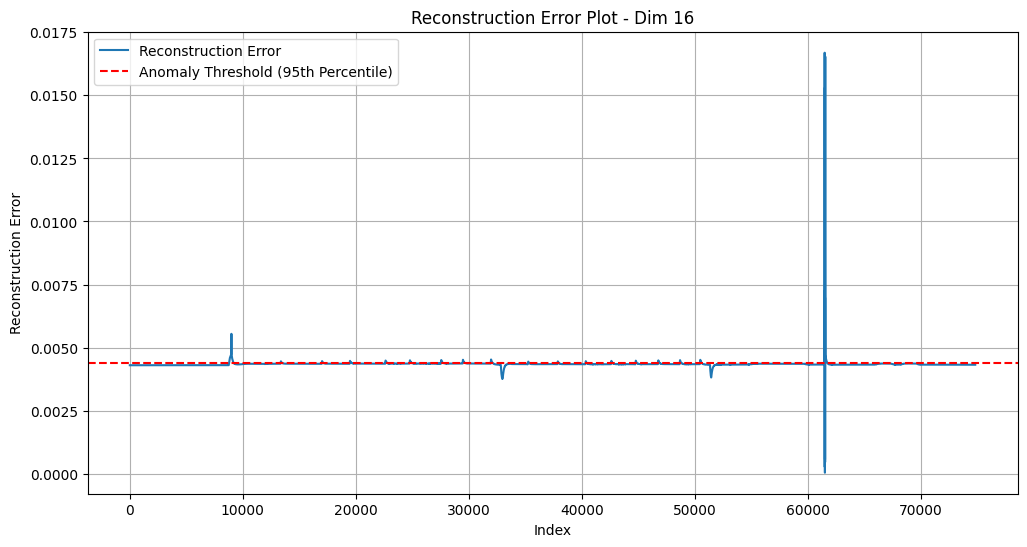

2339/2339 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step


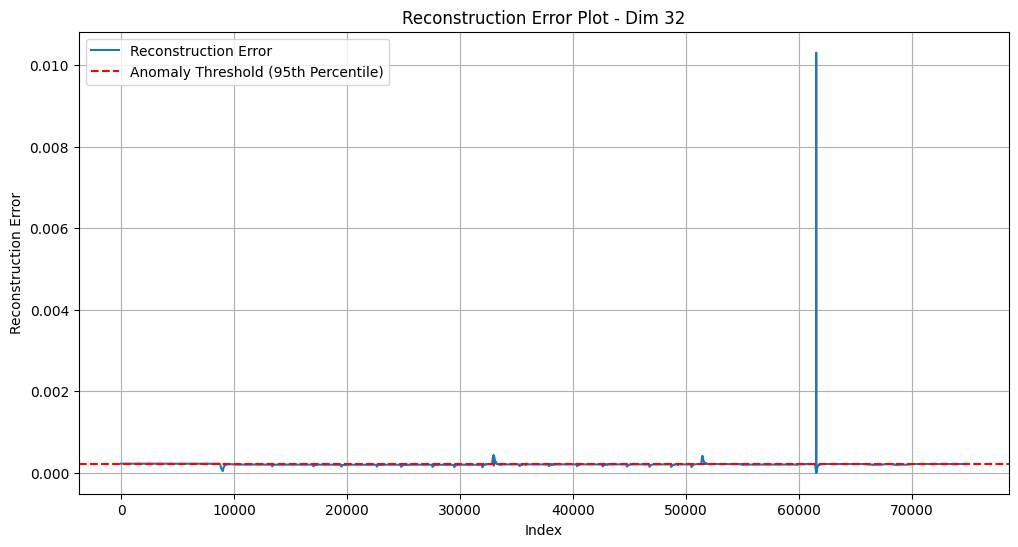

2339/2339 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step


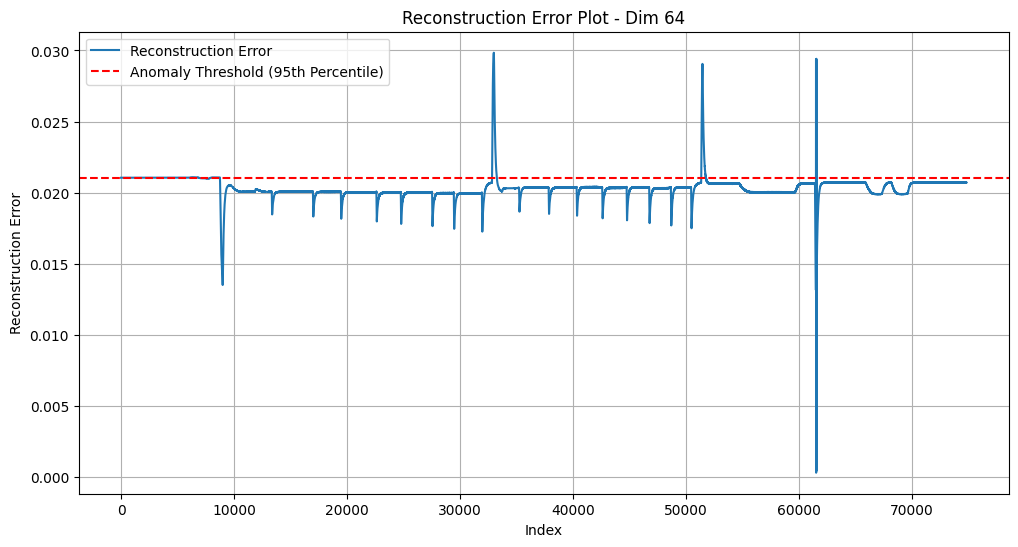

2339/2339 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step


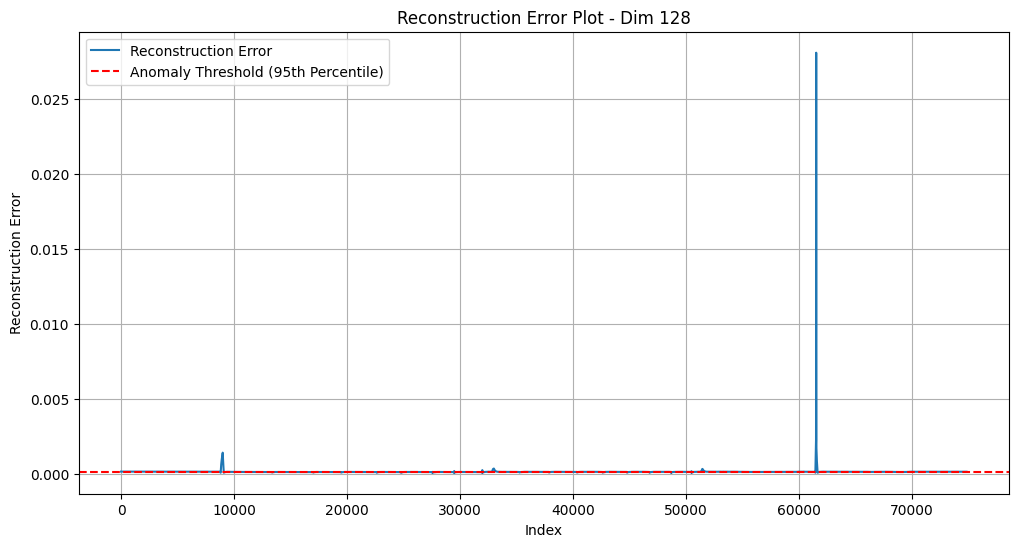

{'Dataset': 'CMX1_AL_CP2.csv', 'Latent_Space': 128, 'Num_Peaks': 2352, 'Peak_Indices': [6096, 6097, 6098, 6099, 6100, 6101, 6102, 6103, 6104, 6105, 6106, 6107, 6108, 6109, 6110, 6111, 6112, 6113, 6136, 6137, 6138, 6139, 6140, 6141, 6142, 6143, 6144, 6145, 6146, 6147, 6148, 6149, 6150, 6151, 6152, 6153, 6154, 6155, 6156, 6157, 6158, 6159, 6160, 6161, 6162, 6163, 6164, 6165, 6185, 6186, 6187, 6188, 6189, 6190, 6191, 6192, 6193, 6194, 6195, 6196, 6197, 6198, 6199, 6200, 6201, 6202, 6203, 6204, 6205, 6206, 6207, 6208, 6209, 6210, 6211, 6212, 6213, 6214, 6215, 6216, 6217, 6218, 6219, 6220, 6221, 6222, 6223, 6224, 6225, 6226, 6227, 6228, 6229, 6230, 6231, 6232, 6233, 6234, 6235, 6236, 6237, 6238, 6239, 6240, 6241, 6242, 6243, 6244, 6245, 6246, 6247, 6248, 6249, 6250, 6251, 6252, 6253, 6254, 6255, 6256, 6257, 6258, 6259, 6260, 6261, 6262, 6263, 6264, 6265, 6266, 6267, 6268, 6269, 6270, 6271, 6272, 6273, 6274, 6275, 6276, 6277, 6278, 6279, 6280, 6281, 6282, 6283, 6284, 6285, 6286, 6287, 6288, 

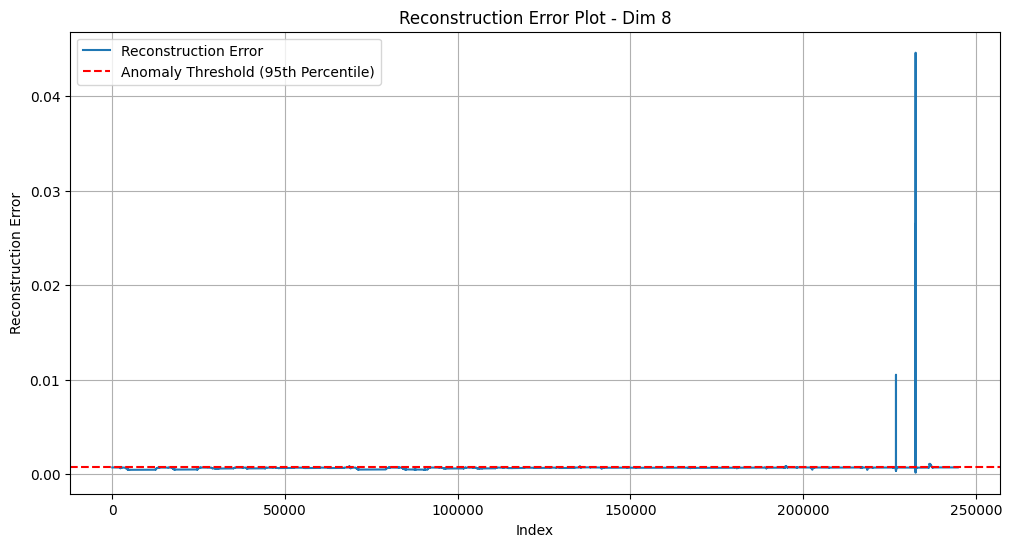

7650/7650 ━━━━━━━━━━━━━━━━━━━━ 9s 1ms/step


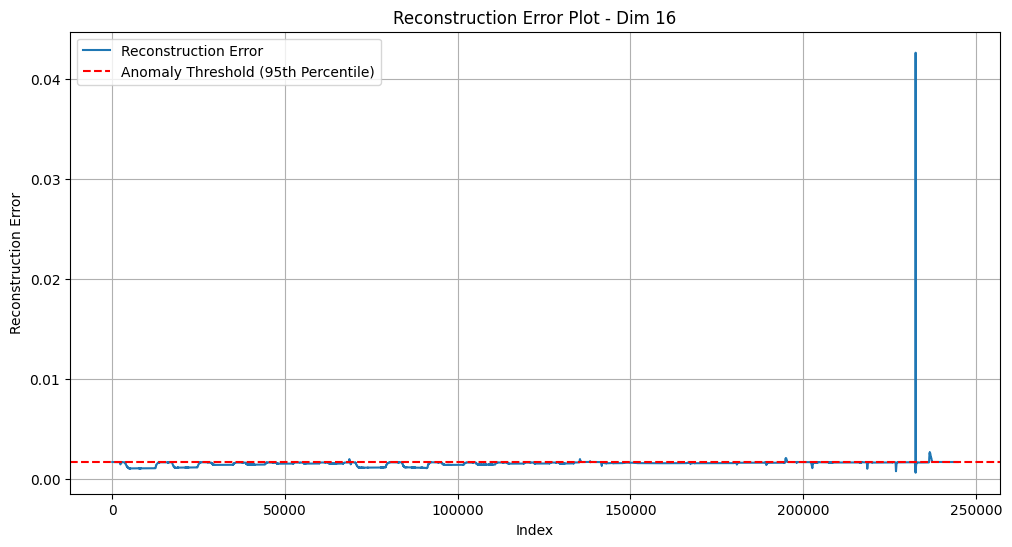

7650/7650 ━━━━━━━━━━━━━━━━━━━━ 8s 985us/step


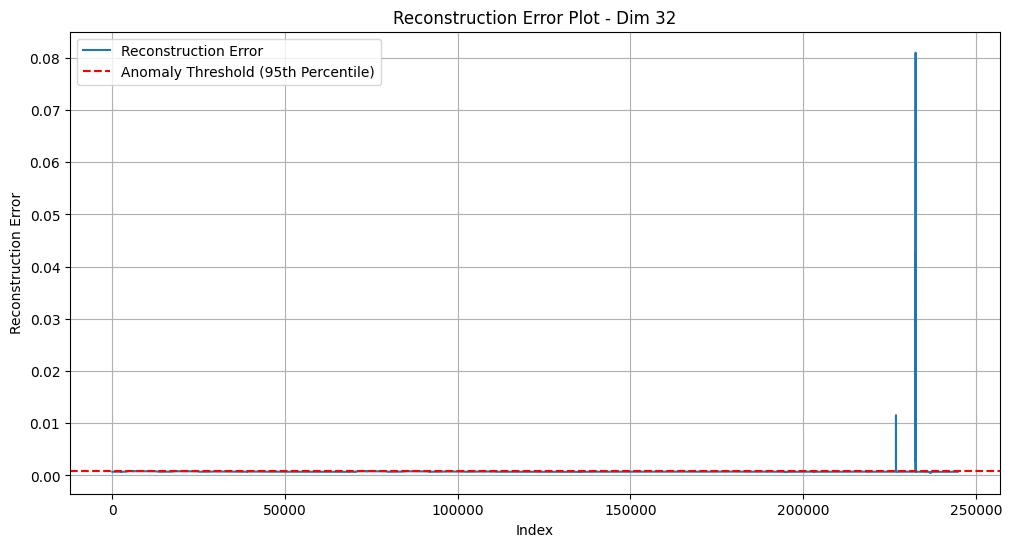

7650/7650 ━━━━━━━━━━━━━━━━━━━━ 9s 1ms/step


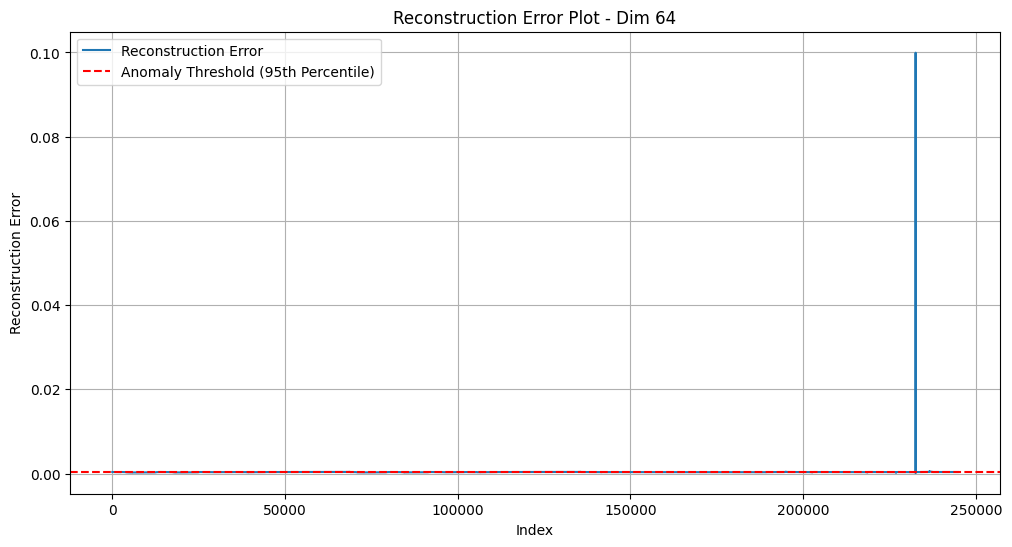

7650/7650 ━━━━━━━━━━━━━━━━━━━━ 8s 1ms/step


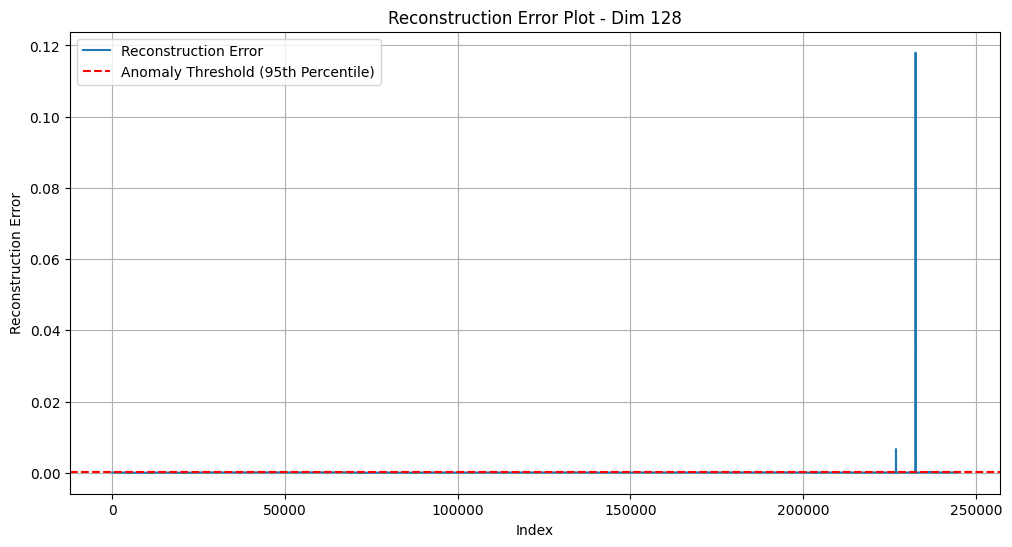

{'Dataset': 'CMX1_S_CP1.csv', 'Latent_Space': 128, 'Num_Peaks': 11157, 'Peak_Indices': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 20

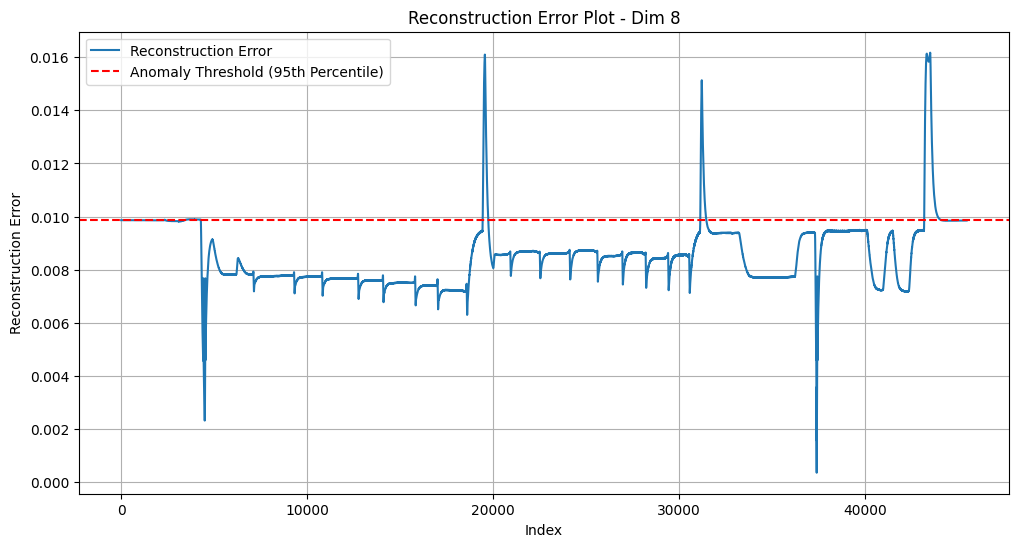

1421/1421 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step


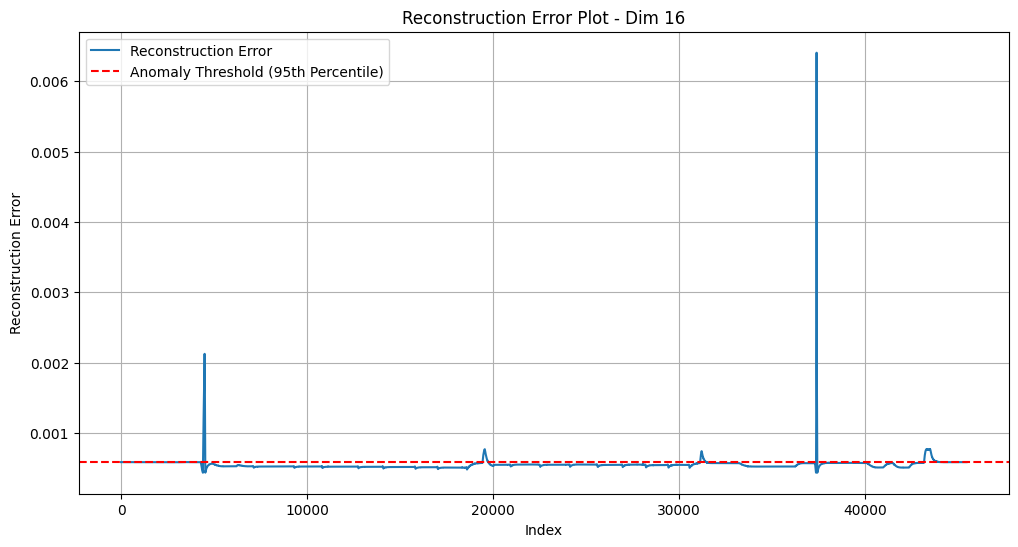

1421/1421 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step


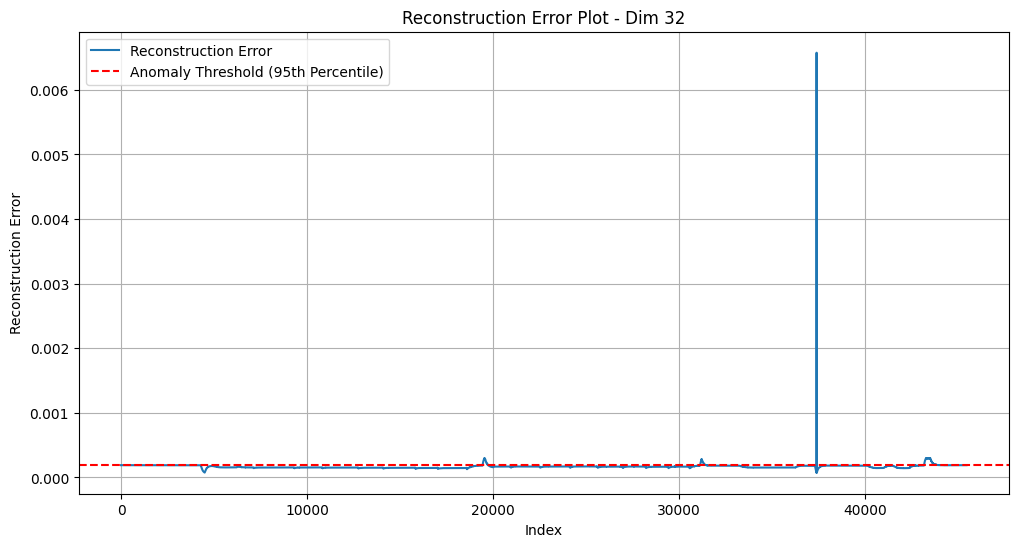

1421/1421 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step


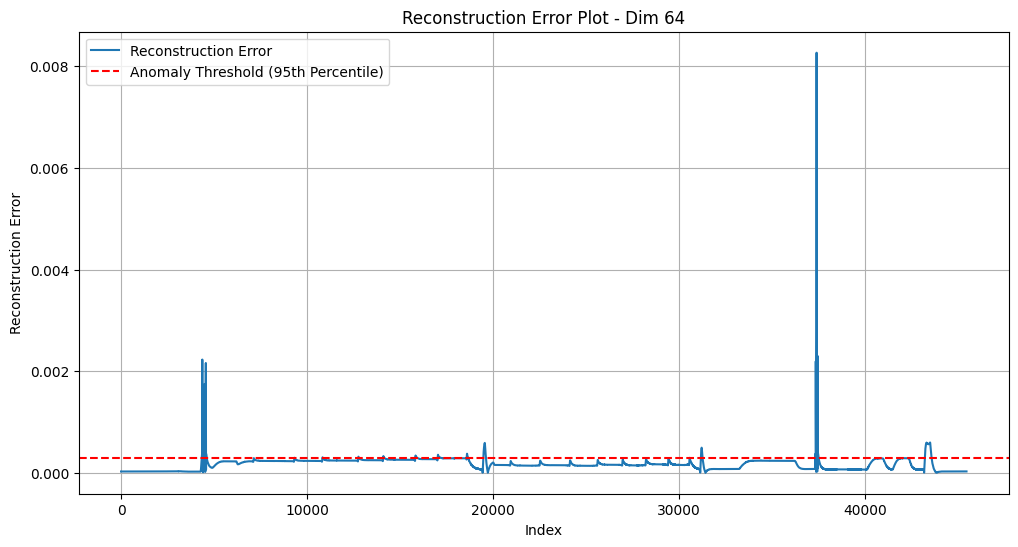

1421/1421 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step


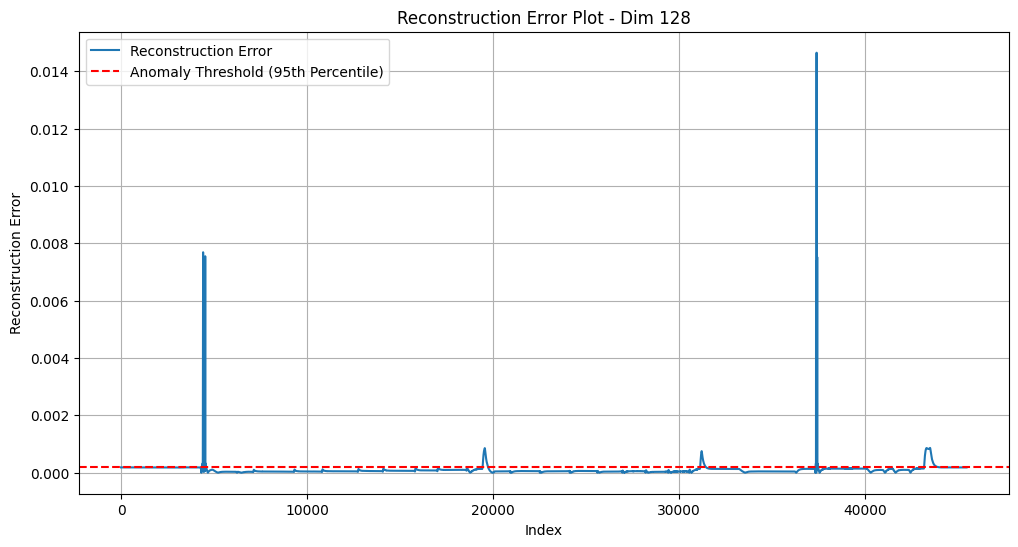

{'Dataset': 'CMX1_S_CP2.csv', 'Latent_Space': 128, 'Num_Peaks': 2219, 'Peak_Indices': [3490, 3491, 3492, 3493, 3494, 3495, 3496, 3497, 3498, 3499, 3500, 3501, 3502, 3503, 3504, 3505, 3506, 3582, 3583, 3584, 3585, 3586, 3587, 3588, 3589, 3590, 3591, 3592, 3593, 3594, 3595, 3596, 3597, 3598, 3599, 3600, 3601, 3602, 3603, 3604, 3605, 3606, 3607, 3608, 3609, 3610, 3611, 3612, 3613, 3614, 3615, 3616, 3617, 3618, 3619, 3620, 3621, 3622, 3623, 3624, 3625, 3626, 3627, 3628, 3629, 3630, 3631, 3632, 3633, 3634, 3635, 3636, 3637, 3638, 3639, 3640, 3641, 3642, 3643, 3644, 3645, 3646, 3647, 3648, 3649, 3650, 3651, 3652, 3653, 3654, 3655, 3656, 3657, 3658, 3659, 3660, 3661, 3662, 3663, 3664, 3665, 3666, 3667, 3668, 3669, 3670, 3671, 3672, 3673, 3674, 3675, 3676, 3677, 3678, 3679, 3680, 3681, 3682, 3683, 3684, 3685, 3686, 3687, 3688, 3689, 3690, 3691, 3692, 3693, 3694, 3695, 3696, 3697, 3698, 3699, 3700, 3701, 3702, 3703, 3704, 3705, 3706, 3707, 3708, 3709, 3710, 3711, 3712, 3713, 3714, 3715, 3716, 3

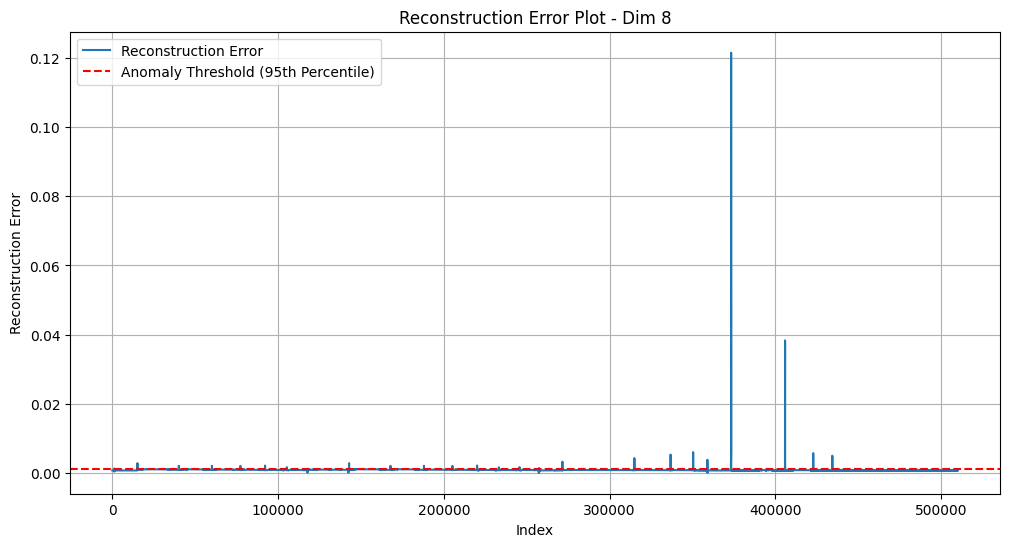

15940/15940 ━━━━━━━━━━━━━━━━━━━━ 17s 1ms/step


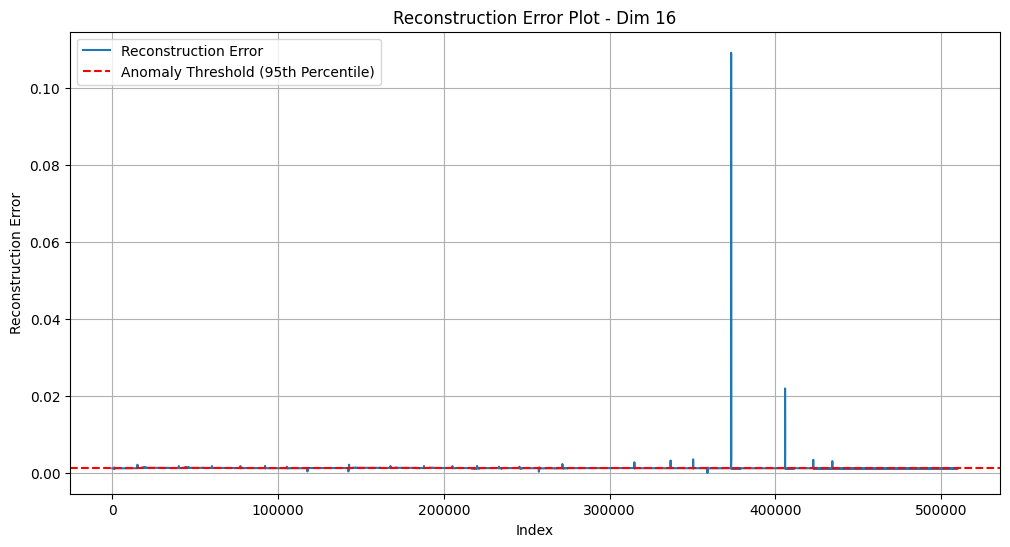

15940/15940 ━━━━━━━━━━━━━━━━━━━━ 13s 829us/step


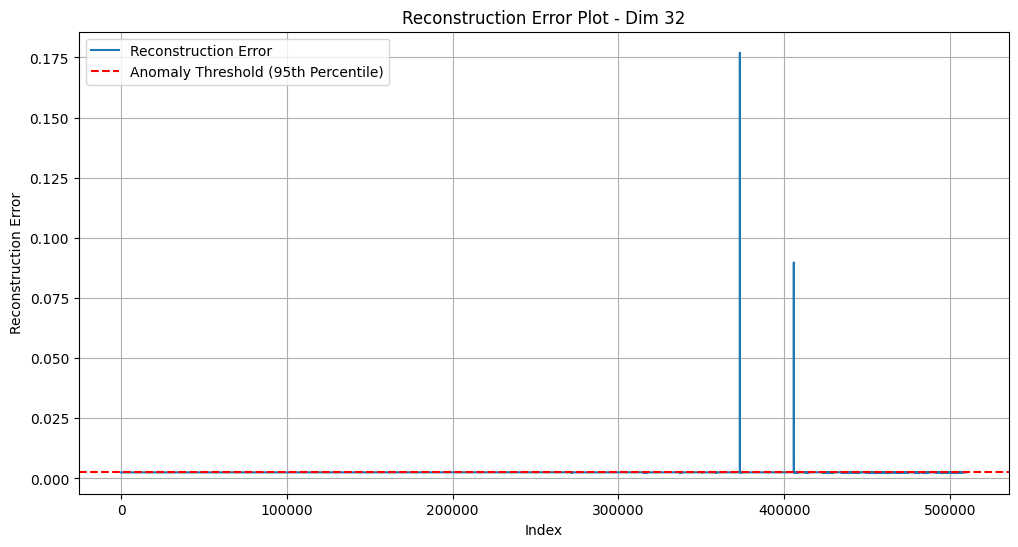

15940/15940 ━━━━━━━━━━━━━━━━━━━━ 10s 652us/step


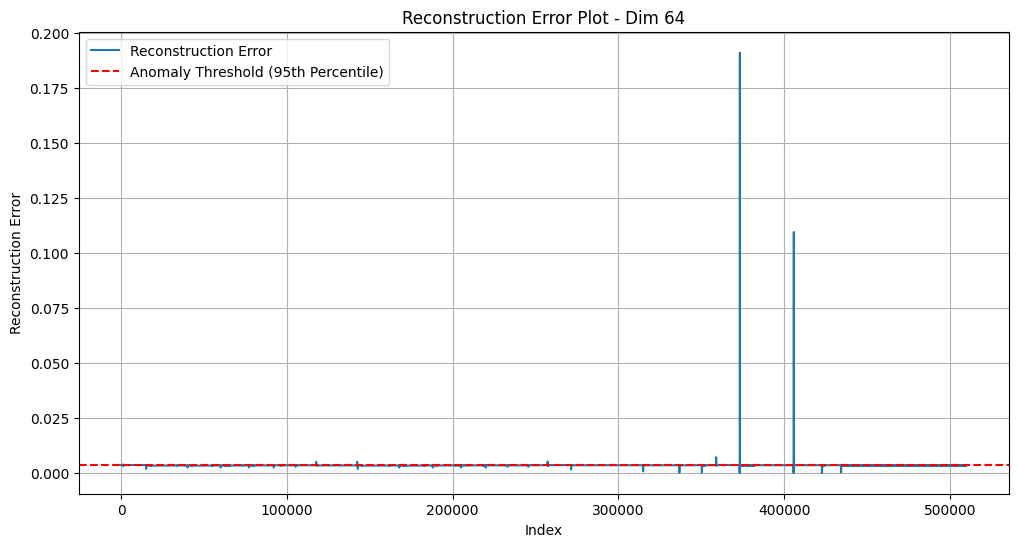

15940/15940 ━━━━━━━━━━━━━━━━━━━━ 11s 689us/step


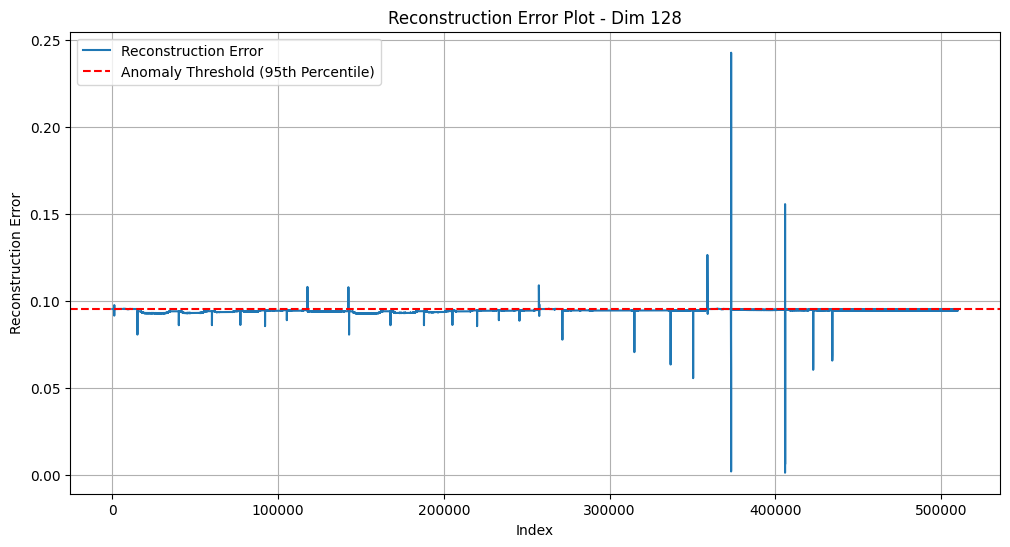

{'Dataset': 'DMC2_AL_CP1.csv', 'Latent_Space': 128, 'Num_Peaks': 9347, 'Peak_Indices': [1195, 1196, 1197, 1198, 1199, 1200, 1201, 1202, 1203, 1204, 1205, 1206, 1207, 1208, 1209, 1210, 1211, 1212, 1213, 1214, 1215, 1216, 1217, 1218, 1219, 1220, 1221, 1222, 1223, 1224, 1225, 1226, 1227, 1228, 1229, 1230, 1231, 1232, 6870, 6871, 6872, 6873, 6874, 6875, 6876, 6877, 6878, 6879, 6880, 6881, 6882, 6883, 6884, 6885, 6886, 6887, 6888, 6889, 6890, 6891, 6892, 6893, 6894, 6895, 6896, 6897, 6898, 6899, 6900, 6901, 6902, 6903, 6904, 6905, 6906, 6907, 6908, 6909, 6910, 6911, 6912, 6913, 6914, 6915, 6916, 6917, 6918, 6919, 6920, 6921, 6922, 6923, 6924, 6925, 6926, 6927, 6928, 6929, 6930, 6931, 6932, 6933, 6934, 6935, 6936, 6937, 6938, 6939, 6940, 6941, 6942, 6943, 6944, 6945, 6946, 6947, 6948, 6949, 6950, 6951, 6952, 6953, 6954, 6955, 6956, 6957, 6958, 6959, 6960, 6961, 6962, 6963, 6964, 6965, 6966, 6967, 6968, 6969, 6970, 6971, 6972, 6973, 6974, 6975, 6976, 6977, 6978, 6979, 6980, 6981, 6982, 6983, 

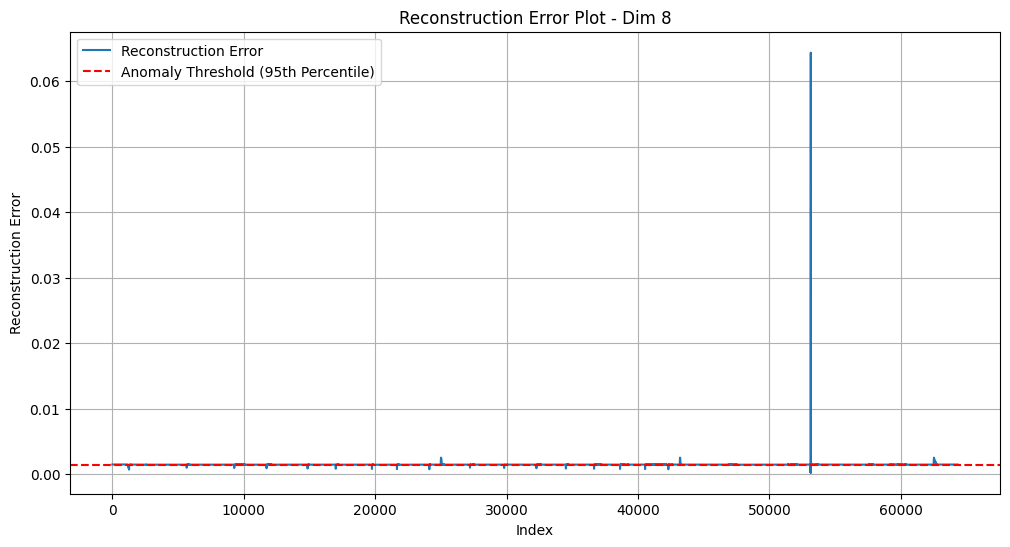

2011/2011 ━━━━━━━━━━━━━━━━━━━━ 1s 678us/step


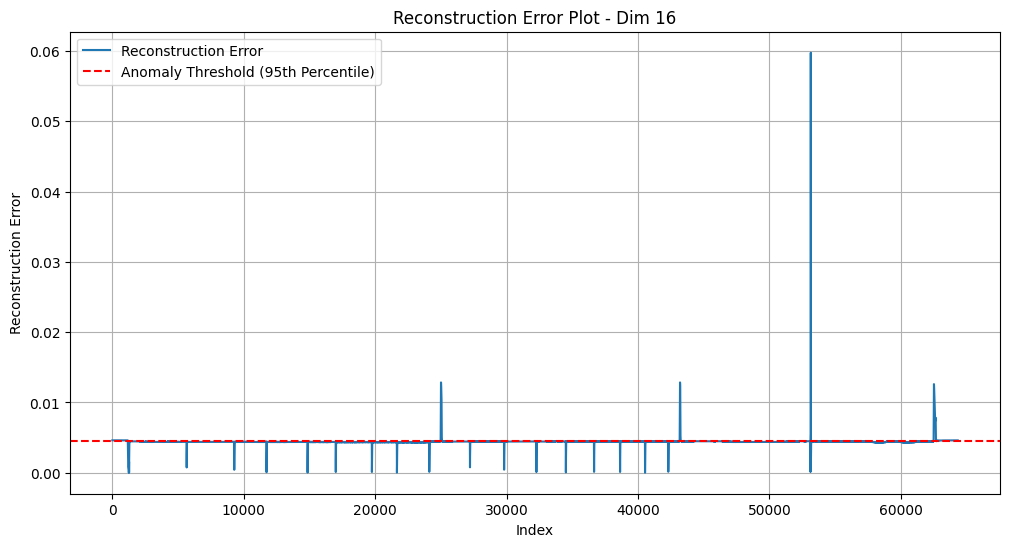

2011/2011 ━━━━━━━━━━━━━━━━━━━━ 1s 664us/step


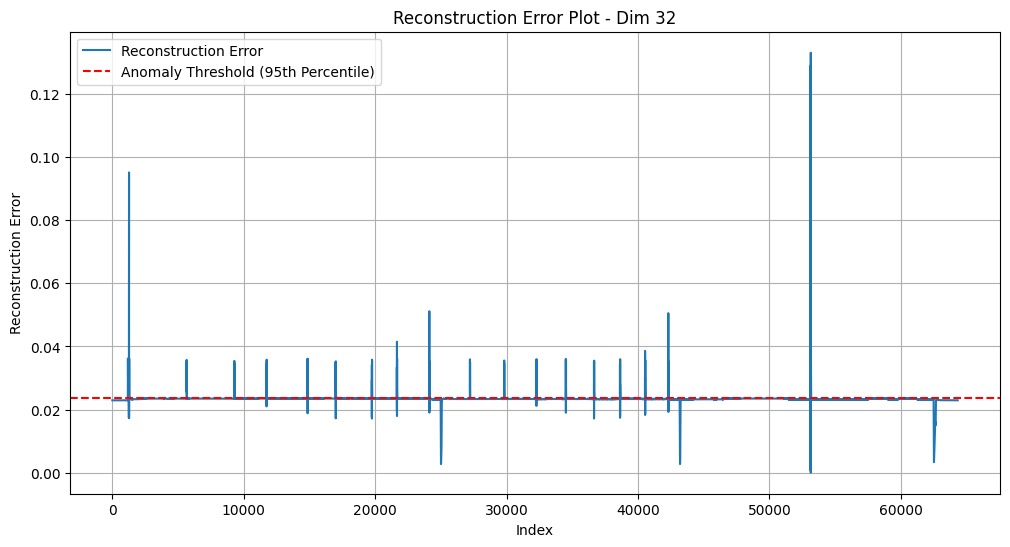

2011/2011 ━━━━━━━━━━━━━━━━━━━━ 1s 671us/step


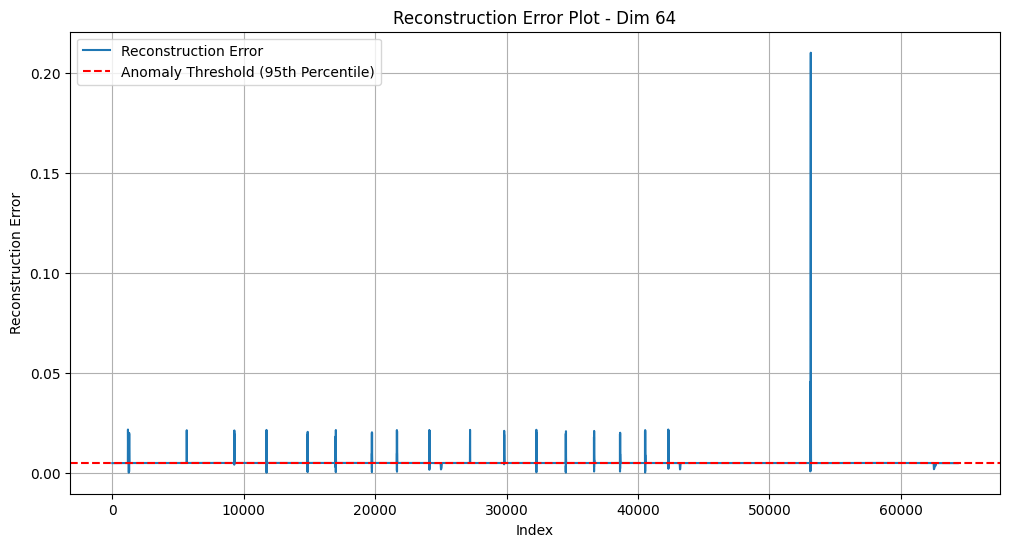

2011/2011 ━━━━━━━━━━━━━━━━━━━━ 1s 688us/step


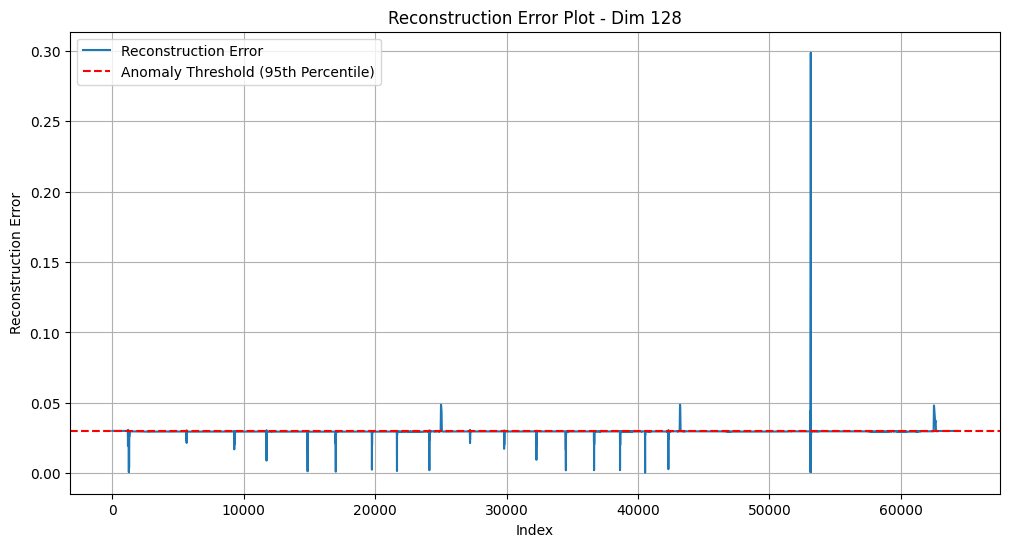

{'Dataset': 'DMC2_AL_CP2.csv', 'Latent_Space': 128, 'Num_Peaks': 3213, 'Peak_Indices': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 20

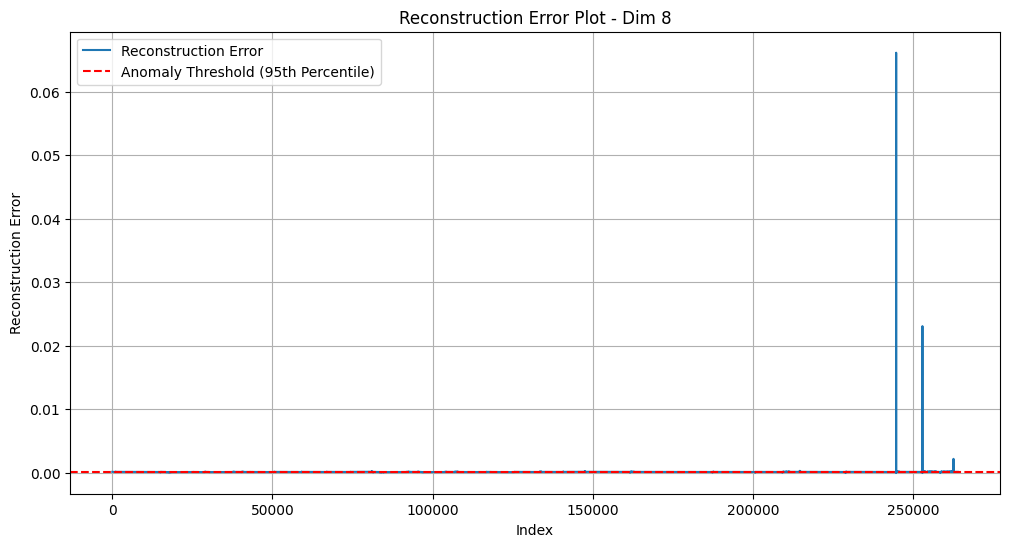

8248/8248 ━━━━━━━━━━━━━━━━━━━━ 5s 649us/step


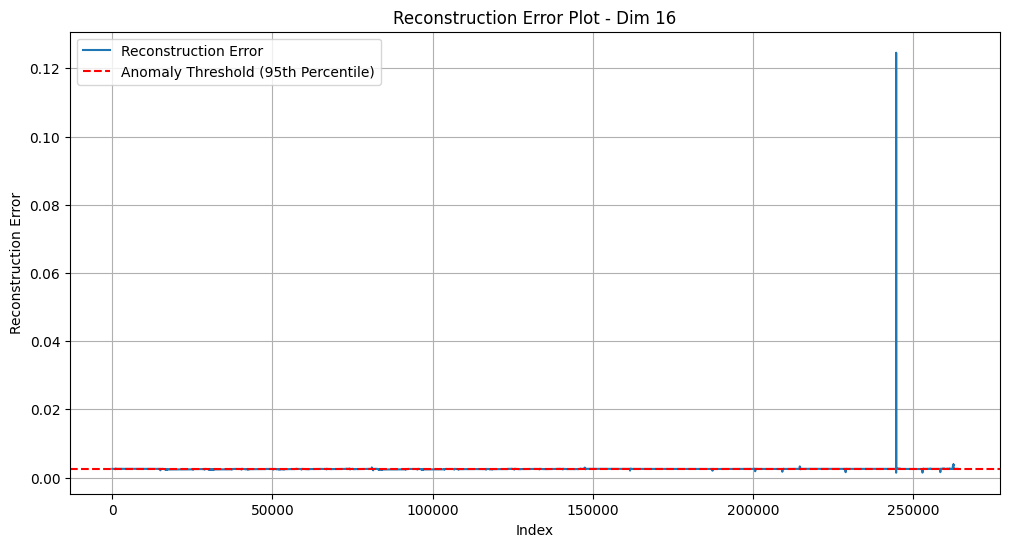

8248/8248 ━━━━━━━━━━━━━━━━━━━━ 5s 647us/step


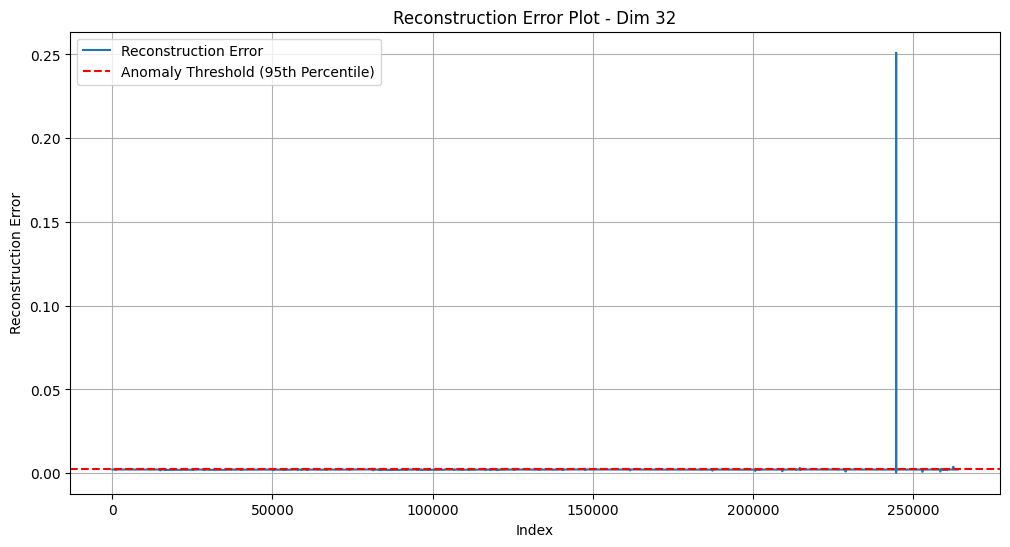

8248/8248 ━━━━━━━━━━━━━━━━━━━━ 5s 662us/step


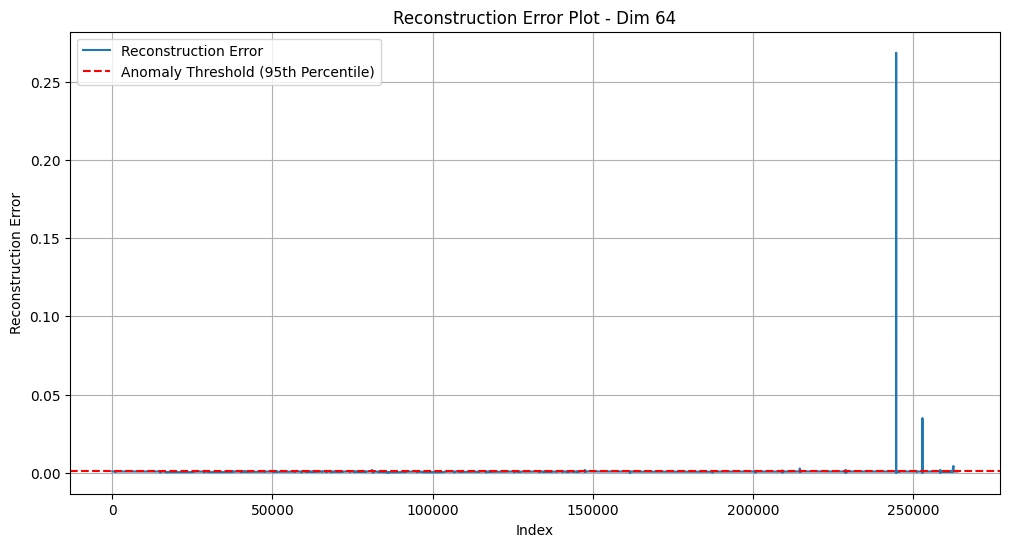

8248/8248 ━━━━━━━━━━━━━━━━━━━━ 5s 659us/step


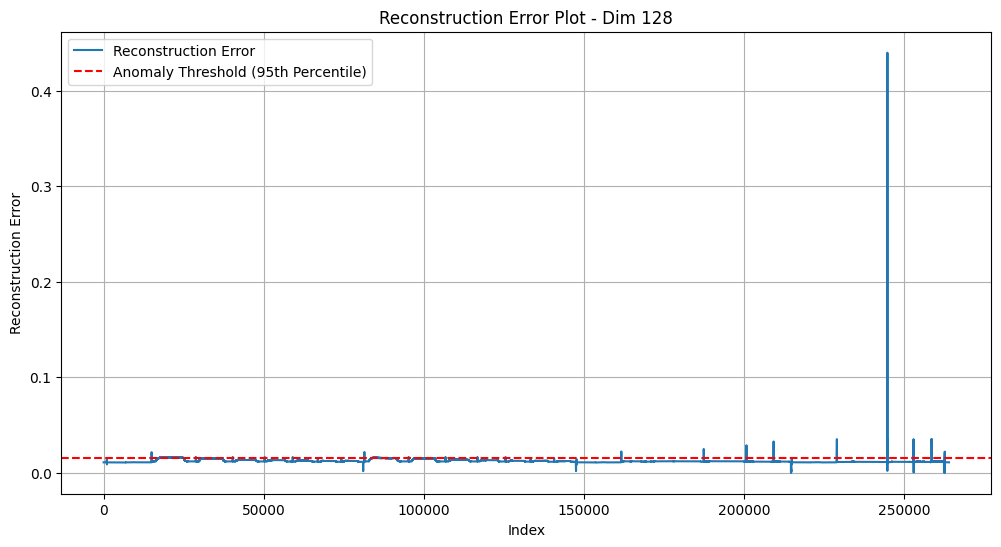

{'Dataset': 'DMC2_S_CP1.csv', 'Latent_Space': 128, 'Num_Peaks': 13132, 'Peak_Indices': [14978, 14979, 14980, 14981, 14982, 14983, 14984, 14985, 14986, 14987, 14988, 14989, 14990, 14991, 14992, 14993, 14994, 14995, 14996, 14997, 14998, 14999, 15000, 15001, 15002, 15003, 15004, 15005, 15006, 15007, 15008, 15009, 15010, 15011, 15012, 15013, 15014, 17165, 17166, 17167, 17202, 17203, 17204, 17205, 17211, 17212, 17213, 17221, 17222, 17223, 17239, 17240, 17241, 17242, 17243, 17244, 17247, 17248, 17249, 17250, 17251, 17257, 17258, 17259, 17260, 17261, 17276, 17277, 17278, 17279, 17280, 17281, 17282, 17283, 17284, 17285, 17286, 17287, 17288, 17289, 17290, 17294, 17295, 17296, 17297, 17298, 17299, 17313, 17314, 17315, 17316, 17317, 17318, 17319, 17320, 17321, 17322, 17323, 17324, 17325, 17326, 17327, 17328, 17329, 17330, 17331, 17332, 17333, 17334, 17335, 17336, 17337, 17350, 17351, 17352, 17353, 17354, 17355, 17356, 17357, 17358, 17359, 17360, 17361, 17362, 17363, 17364, 17365, 17366, 17367, 17

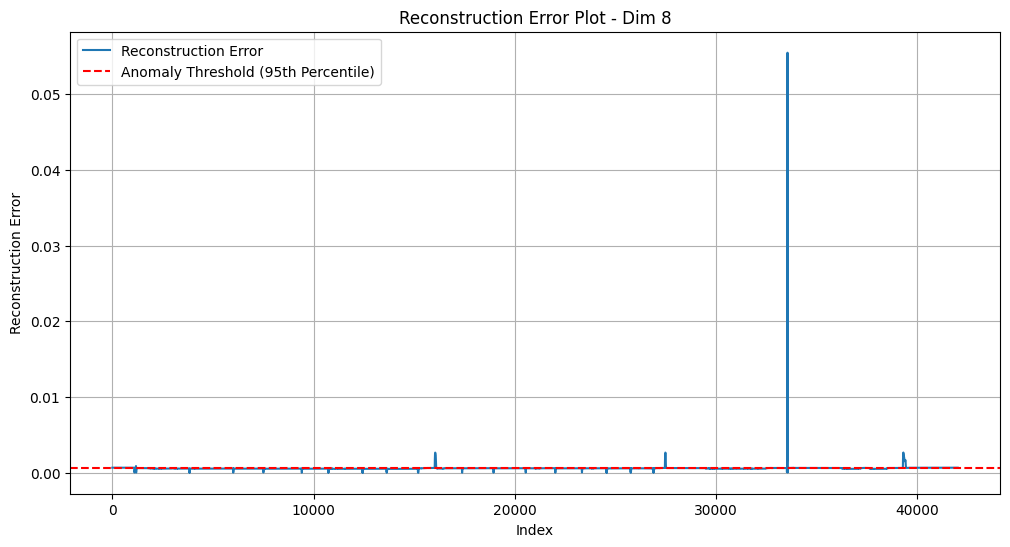

1313/1313 ━━━━━━━━━━━━━━━━━━━━ 1s 611us/step


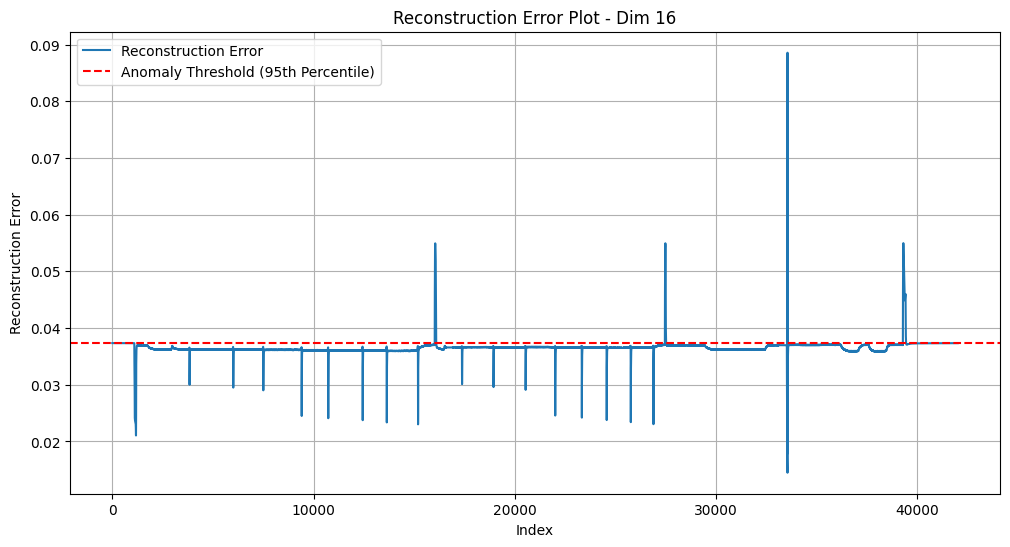

1313/1313 ━━━━━━━━━━━━━━━━━━━━ 1s 650us/step


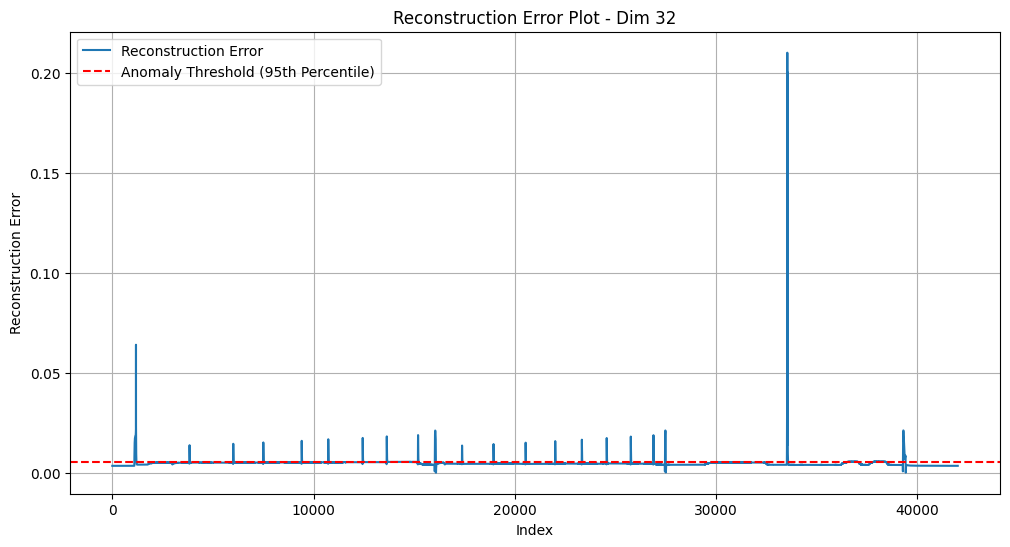

1313/1313 ━━━━━━━━━━━━━━━━━━━━ 1s 650us/step


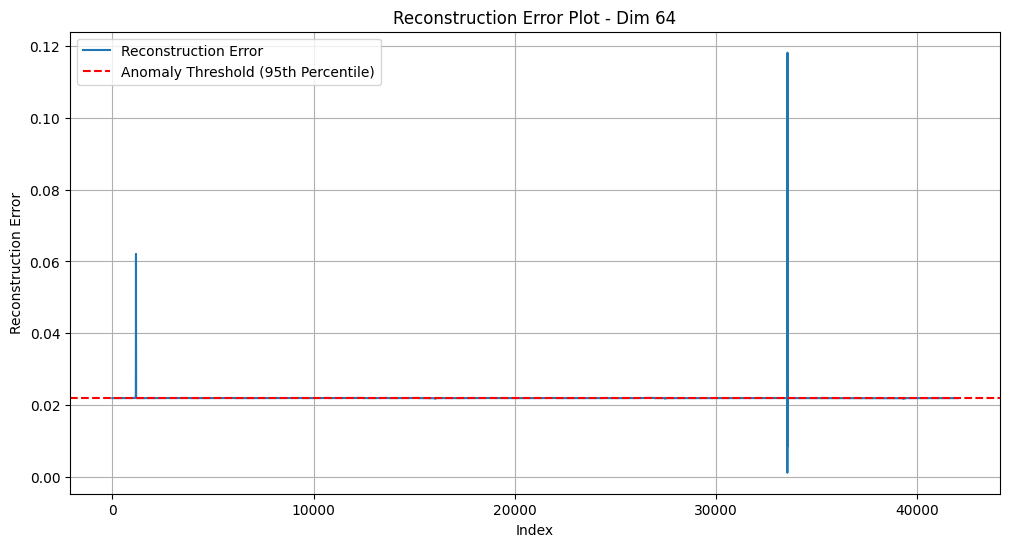

1313/1313 ━━━━━━━━━━━━━━━━━━━━ 1s 655us/step


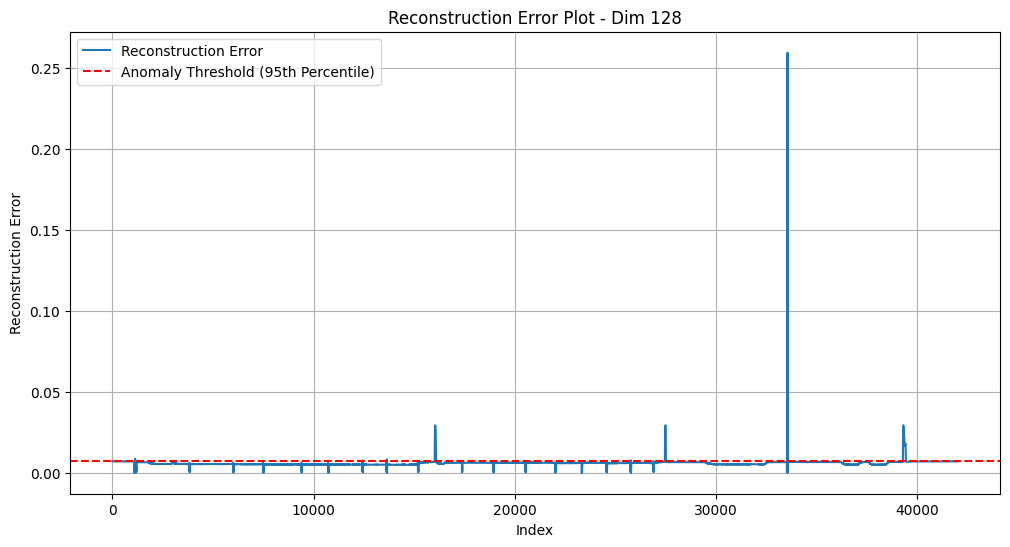

{'Dataset': 'DMC2_S_CP2.csv', 'Latent_Space': 128, 'Num_Peaks': 1926, 'Peak_Indices': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204

In [33]:
latent_dim = [8, 16, 32, 64, 128]
data_rows = []
for file in file_path:
    df = pd.read_csv(file)
    X = df[not_non_features]
    y = df[[target]]
    scaler_X, scaler_y, scaled_X, scaled_y = LSTMinstance.normalize(X, y)
    input_dim = scaled_y.shape[1]

    for dim in latent_dim:
        autoencoder = autoencodermodel(input_dim, dim)
        history = autoencoder.fit(
            scaled_y, scaled_y,
            epochs=50,
            batch_size=32,
            verbose=0)
        
        reconstructed_y = autoencoder.predict(scaled_y)
        #reconstruction_errors = np.abs(scaled_y - reconstructed_y)
        reconstructed_y_original = scaler_y.inverse_transform(reconstructed_y)
        reconstruction_errors = np.abs(y.values.flatten() - reconstructed_y_original.flatten())

        threshold = np.percentile(reconstruction_errors, 95)
        peaks = [(index, value) for index, value in enumerate(y.values.flatten()) if reconstruction_errors[index] > threshold]
        peak_indices = [peak[0] for peak in peaks]
        num_peaks = len(peaks)
        data_row = {
            'Dataset': os.path.basename(file),
            'Latent_Space': dim,
            'Num_Peaks': num_peaks,
            'Peak_Indices': peak_indices
        }
        
        data_rows.append(data_row)
        plt.figure(figsize=(12, 6))
        plt.plot(reconstruction_errors, label="Reconstruction Error")
        plt.axhline(y=threshold, color="r", linestyle="--", label="Anomaly Threshold (95th Percentile)")
        plt.title(f"Reconstruction Error Plot - Dim {dim}")
        plt.xlabel("Index")
        plt.ylabel("Reconstruction Error")
        plt.legend()
        plt.grid()
        plt.show()

    print(data_rows)
df_ae_peaks = pd.DataFrame(data_rows)
df_ae_peaks.to_csv(os.path.join(output_folder, "Autoencoder_Peaks.csv"), index=False)


In [34]:
new_df_ae_peaks = df_ae_peaks.drop(columns=["Peak_Indices"])
print(new_df_ae_peaks)

            Dataset  Latent_Space  Num_Peaks
0   CMX1_AL_CP1.csv             8      21556
1   CMX1_AL_CP1.csv            16      21480
2   CMX1_AL_CP1.csv            32      20632
3   CMX1_AL_CP1.csv            64      21545
4   CMX1_AL_CP1.csv           128      21299
5   CMX1_AL_CP2.csv             8       3638
6   CMX1_AL_CP2.csv            16       3735
7   CMX1_AL_CP2.csv            32       1741
8   CMX1_AL_CP2.csv            64       2446
9   CMX1_AL_CP2.csv           128       2352
10   CMX1_S_CP1.csv             8      12184
11   CMX1_S_CP1.csv            16      12216
12   CMX1_S_CP1.csv            32      12210
13   CMX1_S_CP1.csv            64      11838
14   CMX1_S_CP1.csv           128      11157
15   CMX1_S_CP2.csv             8       2261
16   CMX1_S_CP2.csv            16       2127
17   CMX1_S_CP2.csv            32       2273
18   CMX1_S_CP2.csv            64       2266
19   CMX1_S_CP2.csv           128       2219
20  DMC2_AL_CP1.csv             8      25300
21  DMC2_A

## Tuned AE

Based on the details from the paper : https://ieeexplore.ieee.org/abstract/document/9030505 , trying to impplement an AE for efficient peak detection, keeping the following points in mind:
- Sliding window size to feed to autoencoder

- Sliding window step. Increasing the step will lead to decrease of training set size and vice versa. So, we take slices from the signal [0… window size], [sliding step… window size + sliding step], [2∗ sliding step… window size+2∗ sliding step] etc.

- Number of layers in neural network

- Number of LSTM neurons in each layer

In [ ]:
def autoencodermodel(input_dim, latent_dim, window_size, lstm_neurons=64, num_layers=2):
    input_seq = Input(shape=(window_size, input_dim))
    
    encoded = LSTM(lstm_neurons, activation='relu', return_sequences=True)(input_seq)
    for _ in range(num_layers - 1):
        encoded = LSTM(lstm_neurons, activation='relu', return_sequences=True)(encoded)
    encoded = LSTM(lstm_neurons, activation='relu', return_sequences=False)(encoded)
    
    bottleneck = Dense(latent_dim, activation='relu')(encoded)
    decoded = RepeatVector(window_size)(bottleneck)
    decoded = LSTM(lstm_neurons, activation='relu', return_sequences=True)(decoded)
    for _ in range(num_layers - 1):
        decoded = LSTM(lstm_neurons, activation='relu', return_sequences=True)(decoded)
    decoded = TimeDistributed(Dense(input_dim))(decoded)
    autoencoder = Model(input_seq, decoded)
    autoencoder.compile(optimizer='adam', loss='mse')
    return autoencoder

-> This takes 1 hour to run one combination.  
Not feasible!

In [10]:
def normalize(self, X, y):
        scaler_X = MinMaxScaler(feature_range=(0, 1))
        scaler_y = MinMaxScaler(feature_range=(0, 1))
        scaled_X = scaler_X.fit_transform(X)
        scaled_y = scaler_y.fit_transform(y)

        return scaler_X, scaler_y, scaled_X, scaled_y

def denormalize(self, train_predict, y_train, test_predict, y_test, scaler_y):
    train_predict_inv = scaler_y.inverse_transform(train_predict)
    y_train_inv = scaler_y.inverse_transform(y_train)
    test_predict_inv = scaler_y.inverse_transform(test_predict)
    y_test_inv = scaler_y.inverse_transform(y_test)
    
    return train_predict_inv, y_train_inv, test_predict_inv, y_test_inv

In [6]:
def autoencodermodel(input_dim, dim, window_size):
        input_layer = Input(shape=(window_size,input_dim))
        flattened = Flatten()(input_layer)
        encoded = Dense(dim, activation='relu')(flattened)
        decoded = Dense(window_size*input_dim, activation='linear')(encoded)
        reshaped_decoded = Reshape((window_size, input_dim))(decoded)
        autoencoder = Model(inputs=input_layer, outputs=reshaped_decoded)
        autoencoder.compile(optimizer='adam', loss='mse')
        return autoencoder

In [7]:
def sliding_window(data, window_size, step):
    windows = []
    indices = []
    for i in range(0, len(data) - window_size, step):
        windows.append(data[i:i + window_size])
        indices.append(list(range(i, i + window_size)))
    return np.array(windows), np.array(indices)


In [ ]:
latent_dim = [8, 16, 32, 64]
window_sizes = [30, 60, 100]  
steps = [5, 10]  

data_rows = []
for file in file_path:
    df = pd.read_csv(file)
    X = df[not_non_features]
    y = df[[target]]
    scaler_X, scaler_y, scaled_X, scaled_y = normalize(X, y)
    
    for window_size in window_sizes:
        for step in steps:
            windows, window_indices = sliding_window(scaled_y, window_size, step)
            input_dim = scaled_y.shape[1]
            
            for dim in latent_dim:

                autoencoder = autoencodermodel(input_dim, dim, window_size)
                history = autoencoder.fit(windows, windows, epochs=50, batch_size=32, verbose=0)
                
                
                reconstructed_windows = autoencoder.predict(windows)
                reconstructed_windows_original = np.array([scaler_y.inverse_transform(w) for w in reconstructed_windows])
                original_windows = np.array([scaler_y.inverse_transform(w) for w in windows])
                reconstruction_errors = np.abs(original_windows - reconstructed_windows_original)
                
                threshold = np.percentile(reconstruction_errors, 95)
                peaks = []
                for i in range(original_windows.shape[0]):  
                    for j in range(original_windows.shape[1]):  
                        if reconstruction_errors[i, j] > threshold:
                            peaks.append((window_indices[i, j], original_windows[i, j]))

                peak_indices = list(set(int(peak[0]) for peak in peaks))  # Remove duplicates
                peak_indices.sort()
                num_peaks = len(peak_indices)
                
                data_row = {
                    'Dataset': os.path.basename(file),
                    'Window_Size': window_size,
                    'Step': step,
                    'Latent_Space': dim,
                    'Num_Peaks': num_peaks,
                    'Peak_Indices': peak_indices
                }
                data_rows.append(data_row)
                print(f"Window size:{window_size}, Step:{step}, Dim:{dim}, Number of Peaks:{num_peaks}")

                df_ae_peaks = pd.DataFrame(data_rows)
                df_ae_peaks.to_csv(os.path.join(output_folder, "Autoencoder_tuned_Peaks_.csv"), index=False)

In [ ]:
#df_ae_peaks = pd.read_csv("C:/Users/genty/Hiwi-TimeSeries/output/Autoencoder/Autoencoder_tuned_Peaks_.csv")
new_df_ae_peaks = df_ae_peaks.drop(columns=["Peak_Indices"])
print(new_df_ae_peaks)

             Dataset  Window_Size  Step  Latent_Space  Num_Peaks
0    CMX1_AL_CP1.csv           30     5             8      95150
1    CMX1_AL_CP1.csv           30     5            16      98792
2    CMX1_AL_CP1.csv           30     5            32     115627
3    CMX1_AL_CP1.csv           30     5            64      98331
4    CMX1_AL_CP1.csv           30    10             8      57083
..               ...          ...   ...           ...        ...
187   DMC2_S_CP2.csv          100     5            64      13032
188   DMC2_S_CP2.csv          100    10             8       4146
189   DMC2_S_CP2.csv          100    10            16       6540
190   DMC2_S_CP2.csv          100    10            32       6283
191   DMC2_S_CP2.csv          100    10            64       8279

[192 rows x 5 columns]


In [14]:
df_ae_peaks = pd.read_csv("C:/Users/genty/Hiwi-TimeSeries/output/Autoencoder/Autoencoder_tuned_Peaks_.csv")

df_ae_peaks = df_ae_peaks[~((df_ae_peaks["Window_Size"] == 100) | (df_ae_peaks["Latent_Space"].isin([8, 32])))]
for dataset, group in df_ae_peaks.groupby("Dataset"):
    file_path = os.path.join(output_folder, f"PeaksInfo/{dataset}_peaks.csv")
    group.to_csv(file_path, index=False)

df_ae_peaks = df_ae_peaks.drop(columns=["Peak_Indices"])
print(df_ae_peaks)

             Dataset  Window_Size  Step  Latent_Space  Num_Peaks
1    CMX1_AL_CP1.csv           30     5            16      98792
3    CMX1_AL_CP1.csv           30     5            64      98331
5    CMX1_AL_CP1.csv           30    10            16      58188
7    CMX1_AL_CP1.csv           30    10            64      58469
9    CMX1_AL_CP1.csv           60     5            16     202403
..               ...          ...   ...           ...        ...
175   DMC2_S_CP2.csv           30    10            64       5252
177   DMC2_S_CP2.csv           60     5            16      11489
179   DMC2_S_CP2.csv           60     5            64      13335
181   DMC2_S_CP2.csv           60    10            16       5622
183   DMC2_S_CP2.csv           60    10            64       8129

[64 rows x 5 columns]


# Statistical Tests

In [15]:
output_folder = "C:/Users/genty/Hiwi-TimeSeries/output/Autoencoder/StatisticalAnalysis/"
anova_results = []
tukey_results = []

In [16]:
# Function to run ANOVA and apply Tukey's test on significant factors
def analyze_dataset(df, filename):
    model = ols('Num_Peaks ~ C(Window_Size) + C(Step) + C(Latent_Space) + \
                 C(Window_Size):C(Step) + C(Window_Size):C(Latent_Space) + C(Step):C(Latent_Space)', 
                 data=df).fit()
    
    anova_table = sm.stats.anova_lm(model, typ=2)
    print("\nANOVA Results:\n", anova_table)
    anova_table["Dataset"] = filename  
    anova_table.to_csv(os.path.join(output_folder, f"anova_{filename}.csv"), index=True)
    
    significant_factors = anova_table[anova_table["PR(>F)"] < 0.05].index.tolist()
    print("\nSignificant Factors:", significant_factors)
    
    tukey_results = []
    # Run Tukey’s HSD for each significant factor
    for factor in significant_factors:
        if "C(" in factor:  
            factor_name = factor.split('(')[1].split(')')[0]
            tukey_test = pairwise_tukeyhsd(df['Num_Peaks'], df[factor_name])
            tukeydf = pd.DataFrame(data=tukey_test._results_table.data[1:], columns=tukey_test._results_table.data[0])
            tukeydf["Dataset"] = filename
            tukeydf["Factor"] = factor_name
            tukey_results.append(tukeydf)
            print(f"\nTukey’s HSD for {factor_name}:\n", tukey_test)

    if tukey_results:
        tukey_results_df = pd.concat(tukey_results, ignore_index=True)
        tukey_results_df.to_csv(os.path.join(output_folder, f"tukey_{filename}.csv"), index=False)

In [17]:
folder_path = "C:/Users/genty/Hiwi-TimeSeries/output/Autoencoder/PeaksInfo/"  
csv_files = glob.glob(os.path.join(folder_path, "*.csv"))

for file in csv_files:
    df = pd.read_csv(file)
    print(f"\n========== Dataset ==========")
    analyze_dataset(df, os.path.basename(file))


========== Dataset ==========

ANOVA Results:
                                       sum_sq   df          F    PR(>F)
C(Window_Size)                  1.067260e+10  1.0  55.785114  0.084732
C(Step)                         7.606008e+09  1.0  39.756181  0.100133
C(Latent_Space)                 6.384500e+05  1.0   0.003337  0.963265
C(Window_Size):C(Step)          9.189613e+08  1.0   4.803360  0.272512
C(Window_Size):C(Latent_Space)  8.580500e+05  1.0   0.004485  0.957429
C(Step):C(Latent_Space)         2.061059e+08  1.0   1.077304  0.488152
Residual                        1.913164e+08  1.0        NaN       NaN

Significant Factors: []

========== Dataset ==========

ANOVA Results:
                                     sum_sq   df         F    PR(>F)
C(Window_Size)                  57191512.5  1.0  5.486429  0.256878
C(Step)                         78952178.0  1.0  7.573948  0.221880
C(Latent_Space)                 21131500.5  1.0  2.027162  0.389805
C(Window_Size):C(Step)            75891

In [18]:
for file in csv_files:
    df = pd.read_csv(file)
    print(f"\n========== Dataset ==========")
    X = df[["Window_Size", "Step", "Latent_Space"]]
    X = sm.add_constant(X)
    y = df["Num_Peaks"]

    model = sm.OLS(y, X).fit()
    print(model.summary())



========== Dataset ==========
                            OLS Regression Results                            
Dep. Variable:              Num_Peaks   R-squared:                       0.933
Model:                            OLS   Adj. R-squared:                  0.882
Method:                 Least Squares   F-statistic:                     18.50
Date:                Sun, 09 Mar 2025   Prob (F-statistic):            0.00828
Time:                        18:13:30   Log-Likelihood:                -87.029
No. Observations:                   8   AIC:                             182.1
Df Residuals:                       4   BIC:                             182.4
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const         9.7

C:\Users\genty\AppData\Roaming\Python\Python312\site-packages\scipy\stats\_axis_nan_policy.py:418: UserWarning: `kurtosistest` p-value may be inaccurate with fewer than 20 observations; only n=8 observations were given.
  return hypotest_fun_in(*args, **kwds)
C:\Users\genty\AppData\Roaming\Python\Python312\site-packages\scipy\stats\_axis_nan_policy.py:418: UserWarning: `kurtosistest` p-value may be inaccurate with fewer than 20 observations; only n=8 observations were given.
  return hypotest_fun_in(*args, **kwds)
C:\Users\genty\AppData\Roaming\Python\Python312\site-packages\scipy\stats\_axis_nan_policy.py:418: UserWarning: `kurtosistest` p-value may be inaccurate with fewer than 20 observations; only n=8 observations were given.
  return hypotest_fun_in(*args, **kwds)



========== Dataset ==========
                            OLS Regression Results                            
Dep. Variable:              Num_Peaks   R-squared:                       0.911
Model:                            OLS   Adj. R-squared:                  0.845
Method:                 Least Squares   F-statistic:                     13.68
Date:                Sun, 09 Mar 2025   Prob (F-statistic):             0.0143
Time:                        18:13:30   Log-Likelihood:                -63.491
No. Observations:                   8   AIC:                             135.0
Df Residuals:                       4   BIC:                             135.3
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const         680

C:\Users\genty\AppData\Roaming\Python\Python312\site-packages\scipy\stats\_axis_nan_policy.py:418: UserWarning: `kurtosistest` p-value may be inaccurate with fewer than 20 observations; only n=8 observations were given.
  return hypotest_fun_in(*args, **kwds)
C:\Users\genty\AppData\Roaming\Python\Python312\site-packages\scipy\stats\_axis_nan_policy.py:418: UserWarning: `kurtosistest` p-value may be inaccurate with fewer than 20 observations; only n=8 observations were given.
  return hypotest_fun_in(*args, **kwds)


                            OLS Regression Results                            
Dep. Variable:              Num_Peaks   R-squared:                       0.852
Model:                            OLS   Adj. R-squared:                  0.742
Method:                 Least Squares   F-statistic:                     7.701
Date:                Sun, 09 Mar 2025   Prob (F-statistic):             0.0388
Time:                        18:13:30   Log-Likelihood:                -91.739
No. Observations:                   8   AIC:                             191.5
Df Residuals:                       4   BIC:                             191.8
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const         8.717e+04   5.39e+04      1.616   

C:\Users\genty\AppData\Roaming\Python\Python312\site-packages\scipy\stats\_axis_nan_policy.py:418: UserWarning: `kurtosistest` p-value may be inaccurate with fewer than 20 observations; only n=8 observations were given.
  return hypotest_fun_in(*args, **kwds)
C:\Users\genty\AppData\Roaming\Python\Python312\site-packages\scipy\stats\_axis_nan_policy.py:418: UserWarning: `kurtosistest` p-value may be inaccurate with fewer than 20 observations; only n=8 observations were given.
  return hypotest_fun_in(*args, **kwds)
C:\Users\genty\AppData\Roaming\Python\Python312\site-packages\scipy\stats\_axis_nan_policy.py:418: UserWarning: `kurtosistest` p-value may be inaccurate with fewer than 20 observations; only n=8 observations were given.
  return hypotest_fun_in(*args, **kwds)


# Data Split

In [20]:
def split_train_test_peak_nonpeak(X,y,peak_indices):
    train_size = int(len(X) * 0.3)
    X_train, X_test = X[:train_size], X[train_size:]
    y_train, y_test = y[:train_size], y[train_size:]

    train_peak_indices = [i for i in peak_indices if i < len(X_train)]
    test_peak_indices = [i for i in peak_indices if i >= len(X_train)]

    X_train_peak = X_train.loc[train_peak_indices]
    y_train_peak = y_train.loc[train_peak_indices]
    X_train_non_peak = X_train.drop(train_peak_indices)
    y_train_non_peak = y_train.drop(train_peak_indices)

    X_test_peak = X_test.loc[test_peak_indices]
    y_test_peak = y_test.loc[test_peak_indices]
    X_test_non_peak = X_test.drop(test_peak_indices)
    y_test_non_peak = y_test.drop(test_peak_indices)
    
    return X_train_peak, y_train_peak, X_train_non_peak, y_train_non_peak, X_test_peak, y_test_peak, X_test_non_peak, y_test_non_peak

In [31]:
def get_best_features(dataset_name):
    anova_file = f"anova_{dataset_name}.csv"
    tukey_file = f"tukey_{dataset_name}.csv"
    anova_df = pd.read_csv(f'C:/Users/genty/Hiwi-TimeSeries/output/Autoencoder/StatisticalAnalysis/{anova_file}')
    tukey_df = pd.read_csv(f'C:/Users/genty/Hiwi-TimeSeries/output/Autoencoder/StatisticalAnalysis/{tukey_file}')

    anova_df["Feature"] = anova_df.iloc[:, 0].str.extract(r'C\((.*?)\)')  
    anova_features = anova_df[anova_df["PR(>F)"] < 0.05]["Feature"].dropna().tolist()
    tukey_features = tukey_df[tukey_df["p-adj"] < 0.05]["Factor"].dropna().tolist()
    best_features = list(set(anova_features) & set(tukey_features))
    
    best_feature_values = {"Window_Size": None, "Step": None, "Latent_Space": None}
    for feature in best_features:
        if feature in best_feature_values:
            best_value_row = tukey_df[(tukey_df["Factor"] == feature) & (tukey_df["reject"] == True)].nsmallest(1, "p-adj")
            if not best_value_row.empty:
                best_feature_values[feature] = int(best_value_row["group1"].values[0])
    if best_feature_values["Window_Size"] is None:
        best_feature_values["Window_Size"] = 30  
    if best_feature_values["Step"] is None:
        best_feature_values["Step"] = 5  
    if best_feature_values["Latent_Space"] is None:
        best_feature_values["Latent_Space"] = 16
        
    return best_feature_values

In [32]:
def get_peak_indices(peak_df, best_feature_values):
    selected_row = peak_df[
        (peak_df["Window_Size"] == best_feature_values.get("Window_Size")) &
        (peak_df["Step"] == best_feature_values.get("Step")) &
        (peak_df["Latent_Space"] == best_feature_values.get("Latent_Space"))
    ]

    if selected_row.empty:
        print(f"No matching peak row found")
        return []
    peak_indices = ast.literal_eval(selected_row["Peak_Indices"].values[0])
    peak_indices = list(map(int, peak_indices))

    return peak_indices

In [33]:
peaks_info_list = ['C:/Users/genty/Hiwi-TimeSeries/output/Autoencoder/PeaksInfo/CMX1_AL_CP1.csv_peaks.csv',
                   'C:/Users/genty/Hiwi-TimeSeries/output/Autoencoder/PeaksInfo/CMX1_AL_CP2.csv_peaks.csv',
                    'C:/Users/genty/Hiwi-TimeSeries/output/Autoencoder/PeaksInfo/CMX1_S_CP1.csv_peaks.csv',
                    'C:/Users/genty/Hiwi-TimeSeries/output/Autoencoder/PeaksInfo/CMX1_S_CP2.csv_peaks.csv',
                    'C:/Users/genty/Hiwi-TimeSeries/output/Autoencoder/PeaksInfo/DMC2_AL_CP1.csv_peaks.csv',
                    'C:/Users/genty/Hiwi-TimeSeries/output/Autoencoder/PeaksInfo/DMC2_AL_CP2.csv_peaks.csv',
                    'C:/Users/genty/Hiwi-TimeSeries/output/Autoencoder/PeaksInfo/DMC2_S_CP1.csv_peaks.csv',
                    'C:/Users/genty/Hiwi-TimeSeries/output/Autoencoder/PeaksInfo/DMC2_S_CP2.csv_peaks.csv']

In [34]:
for i in range(8):
    print("Dataset:", i+1)
    df = pd.read_csv(file_path[i])
    df = df.abs()
    X = df[not_non_features]
    y = df[[target]]

    out_folder = f'C:/Users/genty/Hiwi-TimeSeries/output/Autoencoder/Data_Split/Data{i+1}'
    peak_info = pd.read_csv(peaks_info_list[i])
    peak_info_name = os.path.basename(peaks_info_list[i])
    print(peak_info_name)
    best_feature_values = get_best_features(peak_info_name)
    print(best_feature_values)
    peak_indices_list = get_peak_indices(peak_info, best_feature_values)
    print(peak_indices_list)

    X_train_peak, y_train_peak, X_train_non_peak, y_train_non_peak, X_test_peak, y_test_peak, X_test_non_peak, y_test_non_peak = split_train_test_peak_nonpeak(X,y,peak_indices_list)
    X_train_peak.to_csv(os.path.join(out_folder, f'X_train_p_{os.path.basename(file_path[i])}.csv'), index=True)
    y_train_peak.to_csv(os.path.join(out_folder, f'y_train_p_{os.path.basename(file_path[i])}.csv'), index=True)
    X_train_non_peak.to_csv(os.path.join(out_folder, f'X_train_np_{os.path.basename(file_path[i])}.csv'), index=True)
    y_train_non_peak.to_csv(os.path.join(out_folder, f'y_train_np_{os.path.basename(file_path[i])}.csv'), index=True)
    X_test_peak.to_csv(os.path.join(out_folder, f'X_test_p_{os.path.basename(file_path[i])}.csv'), index=True)
    y_test_peak.to_csv(os.path.join(out_folder, f'y_test_p_{os.path.basename(file_path[i])}.csv'), index=True)
    X_test_non_peak.to_csv(os.path.join(out_folder, f'X_test_np_{os.path.basename(file_path[i])}.csv'), index=True)
    y_test_non_peak.to_csv(os.path.join(out_folder, f'y_test_np_{os.path.basename(file_path[i])}.csv'), index=True)

Dataset: 1
CMX1_AL_CP1.csv_peaks.csv
{'Window_Size': 30, 'Step': 5, 'Latent_Space': 16}
[21, 23, 36, 40, 41, 45, 51, 55, 56, 58, 70, 71, 73, 86, 101, 105, 106, 116, 118, 121, 135, 136, 138, 151, 153, 166, 170, 171, 181, 183, 186, 187, 198, 201, 203, 216, 218, 231, 233, 236, 246, 248, 251, 253, 266, 268, 281, 283, 296, 298, 300, 301, 311, 313, 316, 317, 318, 331, 333, 346, 348, 361, 363, 366, 376, 378, 381, 383, 391, 393, 396, 398, 411, 413, 426, 428, 430, 441, 443, 446, 448, 456, 461, 463, 476, 478, 491, 495, 496, 506, 508, 511, 526, 528, 541, 543, 556, 560, 561, 571, 575, 576, 591, 592, 593, 606, 607, 621, 622, 626, 640, 641, 642, 656, 657, 658, 671, 672, 673, 686, 688, 691, 706, 718, 721, 722, 723, 733, 736, 737, 738, 751, 753, 756, 766, 768, 771, 781, 783, 786, 787, 788, 801, 803, 816, 818, 831, 833, 835, 848, 851, 852, 853, 866, 868, 881, 883, 896, 898, 901, 911, 916, 918, 931, 933, 946, 948, 961, 963, 964, 966, 976, 978, 981, 983, 996, 998, 1011, 1013, 1026, 1029, 1030, 1031, 1041

### Classification

In [35]:
base_folder = 'C:/Users/genty/Hiwi-TimeSeries/output/Autoencoder/Data_Split/'
subfolders = ['Data1', 'Data2', 'Data3', 'Data4', 'Data5', 'Data6', 'Data7', 'Data8']
output_folder = 'C:/Users/genty/Hiwi-TimeSeries/output/Autoencoder/Classification/'

In [36]:
def has_peaks(file_path):
    file_name = os.path.basename(file_path)    
    if 'np' in file_name.lower():
        return 0  
    else:
        return 1  

In [37]:
i = 1
for subfolder in subfolders:
    all_data_df = pd.DataFrame()
    folder_path = os.path.join(base_folder, subfolder)
    for file_name in os.listdir(folder_path):
        if file_name.startswith('X'):
            file_path = os.path.join(folder_path, file_name)
            df = pd.read_csv(file_path, index_col=0)
            target_value = 1 if has_peaks(file_path) else 0
            df['target'] = target_value
            all_data_df = pd.concat([all_data_df, df], ignore_index=False)
    all_data_df.sort_index(inplace=True)

    all_data_df.to_csv(os.path.join(output_folder, f'Data{i}_Classes.csv'), index=False)
    i = i+1

# Classification

In [38]:
folder = 'C:/Users/genty/Hiwi-TimeSeries/output/Autoencoder/Classification/'
classification_result = pd.DataFrame(columns=['dataset', 'train_accuracy', 'test_accuracy', 'train_f1', 'test_f1'])

In [39]:
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, f1_score

import joblib

In [40]:
for file_name in os.listdir(folder)[1:9]:
    print(file_name)
    file_path = os.path.join(folder,file_name)
    df_class = pd.read_csv(file_path)
    X = df_class[not_non_features]
    y = df_class['target'].values.ravel()
    train_size = int(len(X) * 0.2)
    X_train, X_test = X[:train_size], X[train_size:]
    y_train, y_test = y[:train_size], y[train_size:]

    rf_model = RandomForestClassifier(random_state=42, class_weight='balanced')
    xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42, scale_pos_weight=len(y_train) / y_train.sum())

    rf_model.fit(X_train, y_train)
    rf_train_pred = rf_model.predict(X_train)
    rf_test_pred = rf_model.predict(X_test)

    joblib.dump(rf_model, os.path.join(folder, f'1RF_{file_name}.pkl'))


    rf_train_accuracy = accuracy_score(y_train, rf_train_pred)
    rf_test_accuracy = accuracy_score(y_test, rf_test_pred)
    rf_train_f1 = f1_score(y_train, rf_train_pred, average='weighted')
    rf_test_f1 = f1_score(y_test, rf_test_pred, average='weighted')

    result = pd.DataFrame([{
        'dataset': file_name + ' RF',
        'train_accuracy': rf_train_accuracy,
        'test_accuracy': rf_test_accuracy,
        'train_f1': rf_train_f1,
        'test_f1': rf_test_f1
    }])
    classification_result = pd.concat([classification_result, result], ignore_index=True)

    xgb_model.fit(X_train, y_train)
    xgb_train_pred = xgb_model.predict(X_train)
    xgb_test_pred = xgb_model.predict(X_test)

    joblib.dump(xgb_model, os.path.join(folder, f'1XGB_{file_name}.pkl'))


    xgb_train_accuracy = accuracy_score(y_train, xgb_train_pred)
    xgb_test_accuracy = accuracy_score(y_test, xgb_test_pred)
    xgb_train_f1 = f1_score(y_train, xgb_train_pred, average='weighted')
    xgb_test_f1 = f1_score(y_test, xgb_test_pred, average='weighted')

    result = pd.DataFrame([{
        'dataset': file_name + ' XGB',
        'train_accuracy': rf_train_accuracy,
        'test_accuracy': rf_test_accuracy,
        'train_f1': rf_train_f1,
        'test_f1': rf_test_f1
    }])
    classification_result = pd.concat([classification_result, result], ignore_index=True)

classification_result.to_csv(os.path.join(folder, 'Class2080_ResultSummary.csv'), index=False)


Data1_Classes.csv


C:\Users\genty\AppData\Local\Temp\ipykernel_1884\2244081769.py:33: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  classification_result = pd.concat([classification_result, result], ignore_index=True)
C:\Users\genty\AppData\Roaming\Python\Python312\site-packages\xgboost\core.py:158: UserWarning: [22:29:12] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Data2_Classes.csv


C:\Users\genty\AppData\Roaming\Python\Python312\site-packages\xgboost\core.py:158: UserWarning: [22:29:17] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Data3_Classes.csv


C:\Users\genty\AppData\Roaming\Python\Python312\site-packages\xgboost\core.py:158: UserWarning: [22:29:41] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Data4_Classes.csv


C:\Users\genty\AppData\Roaming\Python\Python312\site-packages\xgboost\core.py:158: UserWarning: [22:29:44] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Data5_Classes.csv


C:\Users\genty\AppData\Roaming\Python\Python312\site-packages\xgboost\core.py:158: UserWarning: [22:30:12] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Data6_Classes.csv


C:\Users\genty\AppData\Roaming\Python\Python312\site-packages\xgboost\core.py:158: UserWarning: [22:30:18] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Data7_Classes.csv


C:\Users\genty\AppData\Roaming\Python\Python312\site-packages\xgboost\core.py:158: UserWarning: [22:30:40] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Data8_Classes.csv


C:\Users\genty\AppData\Roaming\Python\Python312\site-packages\xgboost\core.py:158: UserWarning: [22:30:44] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


In [41]:
print(classification_result) #20-80

                  dataset  train_accuracy  test_accuracy  train_f1   test_f1
0    Data1_Classes.csv RF        1.000000       0.787754  1.000000  0.697946
1   Data1_Classes.csv XGB        1.000000       0.787754  1.000000  0.697946
2    Data2_Classes.csv RF        0.999933       0.781165  0.999933  0.685832
3   Data2_Classes.csv XGB        0.999933       0.781165  0.999933  0.685832
4    Data3_Classes.csv RF        1.000000       0.853992  1.000000  0.816598
5   Data3_Classes.csv XGB        1.000000       0.853992  1.000000  0.816598
6    Data4_Classes.csv RF        0.999780       0.826172  0.999780  0.751354
7   Data4_Classes.csv XGB        0.999780       0.826172  0.999780  0.751354
8    Data5_Classes.csv RF        1.000000       0.805117  1.000000  0.718225
9   Data5_Classes.csv XGB        1.000000       0.805117  1.000000  0.718225
10   Data6_Classes.csv RF        0.999456       0.829046  0.999456  0.772057
11  Data6_Classes.csv XGB        0.999456       0.829046  0.999456  0.772057

In [ ]:
print(classification_result) #70-30

                  dataset  train_accuracy  test_accuracy  train_f1   test_f1
0    Data1_Classes.csv RF        0.999962       0.776455  0.999962  0.683304
1   Data1_Classes.csv XGB        0.999962       0.776455  0.999962  0.683304
2    Data2_Classes.csv RF        1.000000       0.779155  1.000000  0.684902
3   Data2_Classes.csv XGB        1.000000       0.779155  1.000000  0.684902
4    Data3_Classes.csv RF        0.999986       0.837243  0.999986  0.807251
5   Data3_Classes.csv XGB        0.999986       0.837243  0.999986  0.807251
6    Data4_Classes.csv RF        0.999927       0.798039  0.999927  0.730109
7   Data4_Classes.csv XGB        0.999927       0.798039  0.999927  0.730109
8    Data5_Classes.csv RF        1.000000       0.795230  1.000000  0.704585
9   Data5_Classes.csv XGB        1.000000       0.795230  1.000000  0.704585
10   Data6_Classes.csv RF        1.000000       0.806732  1.000000  0.738377
11  Data6_Classes.csv XGB        1.000000       0.806732  1.000000  0.738377

# Peak Aware Model

In [19]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import MinMaxScaler

In [53]:
peak_result_df = pd.DataFrame(columns=['Dataset', 'Train_R2', 'Test_R2', 'Train_RMSE', 'Test_RMSE'])
#peak_result_df = pd.read_csv("C:/Users/genty/Hiwi-TimeSeries/output/Autoencoder/PeakAwareModel/Peaks_ResultSummary.csv")
output_folder = 'C:/Users/genty/Hiwi-TimeSeries/output/Autoencoder/PeakAwareModel/'
base_folder = 'C:/Users/genty/Hiwi-TimeSeries/output/Autoencoder/Classification/'
filenamefinal = os.path.join(output_folder, 'Peaks_ResultSummary_2080.csv')

In [43]:
def split_rf(X,y, model):
    train_size = int(len(X) * 0.2)
    X_train, X_test = X[:train_size], X[train_size:]
    y_train, y_test = y[:train_size], y[train_size:]
    
    # Step 2: Use the rfmodel to predict peaks on the training set
    peak_predictions_train = model.predict(X_train)
    peak_predictions_test = model.predict(X_test)

    # Step 3: Separate peak and non-peak data points in the training set
    X_train_peak = X_train[peak_predictions_train == 1]
    y_train_peak = y_train[peak_predictions_train == 1]
    X_train_non_peak = X_train[peak_predictions_train == 0]
    y_train_non_peak = y_train[peak_predictions_train == 0]

    # Step 4: Separate peak and non-peak data points in the test set
    X_test_peak = X_test[peak_predictions_test == 1]
    y_test_peak = y_test[peak_predictions_test == 1]
    X_test_non_peak = X_test[peak_predictions_test == 0]
    y_test_non_peak = y_test[peak_predictions_test == 0]

    return X_train_peak, y_train_peak, X_train_non_peak, y_train_non_peak, X_test_peak, y_test_peak, X_test_non_peak, y_test_non_peak


In [45]:
def split_lstm(X,y, model):
    train_size = int(len(X) * 0.2)

    scaler_X = MinMaxScaler(feature_range=(0, 1))
    scaler_y = MinMaxScaler(feature_range=(0, 1))
    scaler_X.fit(X)
    scaler_y.fit(y)
    X_train, X_test = X[:train_size], X[train_size:]
    y_train, y_test = y[:train_size], y[train_size:]
    peak_predictions_train = model.predict(X_train)
    peak_predictions_test = model.predict(X_test)

    X_train_peak = X_train[peak_predictions_train == 1]
    y_train_peak = y_train[peak_predictions_train == 1]
    X_train_non_peak = X_train[peak_predictions_train == 0]
    y_train_non_peak = y_train[peak_predictions_train == 0]
    X_train_peak = scaler_X.transform(X_train_peak)
    X_train_non_peak = scaler_X.transform(X_train_non_peak)
    y_train_peak = scaler_y.transform(y_train_peak)
    y_train_non_peak = scaler_y.transform(y_train_non_peak)

    X_test_peak = X_test[peak_predictions_test == 1]
    y_test_peak = y_test[peak_predictions_test == 1]
    X_test_non_peak = X_test[peak_predictions_test == 0]
    y_test_non_peak = y_test[peak_predictions_test == 0]
    X_test_peak = scaler_X.transform(X_test_peak)
    y_test_peak = scaler_y.transform(y_test_peak)
    X_test_non_peak = scaler_X.transform(X_test_non_peak)
    y_test_non_peak = scaler_y.transform(y_test_non_peak)

    return X_train_peak, y_train_peak, X_train_non_peak, y_train_non_peak, X_test_peak, y_test_peak, X_test_non_peak, y_test_non_peak, scaler_X, scaler_y


In [46]:
def rf_peaks_model(X_train_peakrf, y_train_peakrf, X_test_peakrf, y_test_peakrf):
    rf_model = RandomForestRegressor()
    rf_model.fit(X_train_peakrf, y_train_peakrf)
    train_pred = rf_model.predict(X_train_peakrf)
    test_pred = rf_model.predict(X_test_peakrf)
    #print(y_pred)
    y_train = y_train_peakrf.squeeze()
    y_test = y_test_peakrf.squeeze()

    train_df = pd.DataFrame({
            'Train_y': y_train,
            'Train_pred_y': train_pred })
    filename = os.path.join(output_folder, f'p_trains_rf_xgb_{os.path.basename(file_path[i])}.csv')
    train_df.to_csv(filename, index=False)

    test_df = pd.DataFrame({
            'Test_y': y_test,
            'Test_pred_y': test_pred })
    filename = os.path.join(output_folder, f'p_tests_rf_xgb_{os.path.basename(file_path[i])}.csv')
    test_df.to_csv(filename, index=False)

    train_mse = mean_squared_error(y_train, train_pred)
    train_rmse = np.sqrt(train_mse)
    train_r2 = r2_score(y_train, train_pred)
    test_mse = mean_squared_error(y_test, test_pred)
    test_rmse = np.sqrt(test_mse)
    test_r2 = r2_score(y_test, test_pred)

    return train_r2, train_rmse, test_r2, test_rmse

In [47]:
def rf_non_peaks_model(X_train_non_peakrf, y_train_non_peakrf, X_test_non_peakrf, y_test_non_peakrf):
    rf_model = RandomForestRegressor()
    rf_model.fit(X_train_non_peakrf, y_train_non_peakrf)
    train_pred = rf_model.predict(X_train_non_peakrf)
    test_pred = rf_model.predict(X_test_non_peakrf)
    #print(y_pred)
    y_train = y_train_non_peakrf.squeeze()
    y_test = y_test_non_peakrf.squeeze()

    train_df = pd.DataFrame({
            'Train_y': y_train,
            'Train_pred_y': train_pred })
    filename = os.path.join(output_folder, f'np_trains_rf_xgb_{os.path.basename(file_path[i])}.csv')
    train_df.to_csv(filename, index=False)

    test_df = pd.DataFrame({
            'Test_y': y_test,
            'Test_pred_y': test_pred })
    filename = os.path.join(output_folder, f'np_tests_rf_xgb_{os.path.basename(file_path[i])}.csv')
    test_df.to_csv(filename, index=False)

    train_mse = mean_squared_error(y_train, train_pred)
    train_rmse = np.sqrt(train_mse)
    train_r2 = r2_score(y_train, train_pred)
    test_mse = mean_squared_error(y_test, test_pred)
    test_rmse = np.sqrt(test_mse)
    test_r2 = r2_score(y_test, test_pred)

    return train_r2, train_rmse, test_r2, test_rmse

In [89]:
i=5
df = pd.read_csv(file_path[i])
df = df.abs()
X = df[not_non_features]
y = df[[target]]
rf_model = joblib.load(os.path.join(base_folder, f'1RF_Data{i+1}_Classes.csv.pkl'))
#xgb_model = joblib.load(os.path.join(base_folder, f'XGB_Data{i+1}_Classes.csv.pkl'))


#X_train_peakrf, y_train_peakrf, X_train_non_peakrf, y_train_non_peakrf, X_test_peakrf, y_test_peakrf, X_test_non_peakrf, y_test_non_peakrf = split_rf(X, y, xgb_model)
X_train_peak, y_train_peak, X_train_non_peak, y_train_non_peak, X_test_peak, y_test_peak, X_test_non_peak, y_test_non_peak, scaler_X, scaler_y = split_lstm(X, y, rf_model)



In [68]:
def create_dataset(X, y, time_step=60):
    if len(X) <= time_step:  
        time_step = len(X) - 1
    Xs, ys = [], []
    for i in range(len(X) - time_step):
        Xs.append(X[i:(i + time_step)])
        ys.append(y[i + time_step])
    return np.array(Xs), np.array(ys)

In [62]:
def build_model(input_shape):
        model = Sequential()
        model.add(LSTM(64, return_sequences=True, input_shape=input_shape))
        model.add(LSTM(32, return_sequences=False))
        model.add(Dense(25))
        model.add(Dense(1))
        model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')
        return model

In [90]:
time_step = 60

X_train, y_train = create_dataset(X_train_peak, y_train_peak, time_step)
X_test, y_test = create_dataset(X_test_peak, y_test_peak, time_step)

input_shape = (X_train.shape[1], X_train.shape[2])
model = build_model(input_shape)  

# Train the model
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test), verbose=1)

# Make Predictions
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)
# Inverse transform predictions
train_predict_inv = scaler_y.inverse_transform(train_predict)
y_train_inv = scaler_y.inverse_transform(y_train)
test_predict_inv = scaler_y.inverse_transform(test_predict)
y_test_inv = scaler_y.inverse_transform(y_test)

train_df = pd.DataFrame({
        'Train_y': y_train_inv.flatten(),
        'Train_pred_y': train_predict_inv.flatten()
    })

filename = os.path.join(output_folder, f'p_trains_lstm_rf_{os.path.basename(file_path[i])}.csv')
train_df.to_csv(filename, index=False)
test_df = pd.DataFrame({
        'Test_y': y_test_inv.flatten(),
        'Test_pred_y': test_predict_inv.flatten()
    })

filename = os.path.join(output_folder, f'p_tests_lstm_rf_{os.path.basename(file_path[i])}.csv')
test_df.to_csv(filename, index=False)

# Calculate R2 and RMSE
train_r2 = r2_score(y_train_inv, train_predict_inv)
test_r2 = r2_score(y_test_inv, test_predict_inv)
train_rmse = np.sqrt(mean_squared_error(y_train_inv, train_predict_inv))
test_rmse = np.sqrt(mean_squared_error(y_test_inv, test_predict_inv))

# Append the results to the dataframe
dum_df = pd.DataFrame([{
    'Dataset': f'Peak_LSTM_RF_{os.path.basename(file_path[i])}',
    'Train_R2': train_r2,
    'Train_RMSE': train_rmse,
    'Test_R2': test_r2,
    'Test_RMSE': test_rmse
}])
peak_result_df = pd.concat([peak_result_df,dum_df], ignore_index=True)
peak_result_df.to_csv(filenamefinal, index=False)

Epoch 1/50


C:\Users\genty\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


46/46 ━━━━━━━━━━━━━━━━━━━━ 5s 41ms/step - loss: 0.0099 - val_loss: 0.0443
Epoch 2/50
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0023 - val_loss: 0.0380
Epoch 3/50
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0018 - val_loss: 0.0274
Epoch 4/50
46/46 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - loss: 0.0014 - val_loss: 0.0228
Epoch 5/50
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 9.5540e-04 - val_loss: 0.0186
Epoch 6/50
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0010 - val_loss: 0.0171
Epoch 7/50
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 7.2716e-04 - val_loss: 0.0163
Epoch 8/50
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 6.5081e-04 - val_loss: 0.0137
Epoch 9/50
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 6.0696e-04 - val_loss: 0.0148
Epoch 10/50
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 3.0616e-04 - val_loss: 0.0139
Epoch 11/50
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 2.8683e-04 - val_loss: 0.0100
Epoch 12/50
46/46 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/ste

In [91]:
time_step = 60

X_train, y_train = create_dataset(X_train_non_peak, y_train_non_peak, time_step)
X_test, y_test = create_dataset(X_test_non_peak, y_test_non_peak, time_step)

input_shape = (X_train.shape[1], X_train.shape[2])
model = build_model(input_shape)

# Train the model
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test), verbose=1)

# Make Predictions
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)
# Inverse transform predictions
train_predict_inv = scaler_y.inverse_transform(train_predict)
y_train_inv = scaler_y.inverse_transform(y_train)
test_predict_inv = scaler_y.inverse_transform(test_predict)
y_test_inv = scaler_y.inverse_transform(y_test)

train_df = pd.DataFrame({
        'Train_y': y_train_inv.flatten(),
        'Train_pred_y': train_predict_inv.flatten()
    })

filename = os.path.join(output_folder, f'np_trains_lstm_rf_{os.path.basename(file_path[i])}.csv')
train_df.to_csv(filename, index=False)
test_df = pd.DataFrame({
        'Test_y': y_test_inv.flatten(),
        'Test_pred_y': test_predict_inv.flatten()
    })

filename = os.path.join(output_folder, f'np_tests_lstm_rf_{os.path.basename(file_path[i])}.csv')
test_df.to_csv(filename, index=False)

# Calculate R2 and RMSE
train_r2 = r2_score(y_train_inv, train_predict_inv)
test_r2 = r2_score(y_test_inv, test_predict_inv)
train_rmse = np.sqrt(mean_squared_error(y_train_inv, train_predict_inv))
test_rmse = np.sqrt(mean_squared_error(y_test_inv, test_predict_inv))

# Append the results to the dataframe
dum_df = pd.DataFrame([{
    'Dataset': f'NonPeak_LSTM_RF_{os.path.basename(file_path[i])}',
    'Train_R2': train_r2,
    'Train_RMSE': train_rmse,
    'Test_R2': test_r2,
    'Test_RMSE': test_rmse
}])
peak_result_df = pd.concat([peak_result_df,dum_df], ignore_index=True)
peak_result_df.to_csv(filenamefinal, index=False)

Epoch 1/50


C:\Users\genty\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


354/354 ━━━━━━━━━━━━━━━━━━━━ 26s 66ms/step - loss: 0.0015 - val_loss: 9.7208e-05
Epoch 2/50
354/354 ━━━━━━━━━━━━━━━━━━━━ 22s 62ms/step - loss: 1.8713e-05 - val_loss: 1.1427e-04
Epoch 3/50
354/354 ━━━━━━━━━━━━━━━━━━━━ 22s 63ms/step - loss: 2.7278e-06 - val_loss: 9.8660e-05
Epoch 4/50
354/354 ━━━━━━━━━━━━━━━━━━━━ 22s 62ms/step - loss: 5.1274e-06 - val_loss: 8.7462e-05
Epoch 5/50
354/354 ━━━━━━━━━━━━━━━━━━━━ 22s 63ms/step - loss: 2.2336e-06 - val_loss: 8.0536e-05
Epoch 6/50
354/354 ━━━━━━━━━━━━━━━━━━━━ 22s 63ms/step - loss: 1.7600e-05 - val_loss: 1.1853e-04
Epoch 7/50
354/354 ━━━━━━━━━━━━━━━━━━━━ 22s 63ms/step - loss: 9.8517e-07 - val_loss: 9.1721e-05
Epoch 8/50
354/354 ━━━━━━━━━━━━━━━━━━━━ 22s 63ms/step - loss: 9.2411e-07 - val_loss: 9.0085e-05
Epoch 9/50
354/354 ━━━━━━━━━━━━━━━━━━━━ 22s 63ms/step - loss: 1.2088e-06 - val_loss: 9.6210e-05
Epoch 10/50
354/354 ━━━━━━━━━━━━━━━━━━━━ 22s 62ms/step - loss: 1.4330e-06 - val_loss: 8.0358e-05
Epoch 11/50
354/354 ━━━━━━━━━━━━━━━━━━━━ 22s 63ms/step